### 원 모델에 대한 시도별 예측

In [1]:
import pandas as pd
import numpy as np
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [20]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')
#

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### RandomForest, XGBoost 데이터 셋 재정리

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

sido create_date  sido_cd  weekend_yn  grid_x  grid_y  sat_x  sat_y  \
0   경기도  2014-05-01       31           0      60     120    NaN    NaN   
1  충청북도  2014-05-01       33           0      69     107    NaN    NaN   

   min_ta  max_ta  ...  ta_mean_six_am2  ta_min_six_pm1  ta_max_six_pm1  \
0     9.6    24.2  ...               15              21              24   
1    10.5    23.7  ...               15              21              23   

   ta_mean_six_pm1  ta_min_six_pm2  ta_max_six_pm2  ta_mean_six_pm2  \
0               22              14              21               17   
1               22              15              22               18   

   patientsCnt    instDate    updtDate  
0            0  2024-07-31  2024-07-31  
1            0  2024-07-31  2024-07-31  

[2 rows x 58 columns]

In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [7]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

### RandomForest Modeling

In [8]:
# RandomForestRegressor 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 평가
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Regressor:")
print(f'Training MAE: {mae_train_rf}')
print(f'Training RMSE: {rmse_train_rf}')
print(f'Training R2: {r2_train_rf}')
print()
print(f'Test MAE: {mae_test_rf}')
print(f'Test RMSE: {rmse_test_rf}')
print(f'Test R2: {r2_test_rf}')

### XGBoost Modeling

In [9]:
# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(random_state=11)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# 평가
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Regressor:")
print(f'Training MAE: {mae_train_xgb}')
print(f'Training RMSE: {rmse_train_xgb}')
print(f'Training R2: {r2_train_xgb}')
print()
print(f'Test MAE: {mae_test_xgb}')
print(f'Test RMSE: {rmse_test_xgb}')
print(f'Test R2: {r2_test_xgb}')

XGBoost Regressor:
Training MAE: 0.2538571333627487
Training RMSE: 0.4731666935762716
Training R2: 0.959177752647343

Test MAE: 0.5166442152973487
Test RMSE: 1.2281980105213979
Test R2: 0.7513134464709706


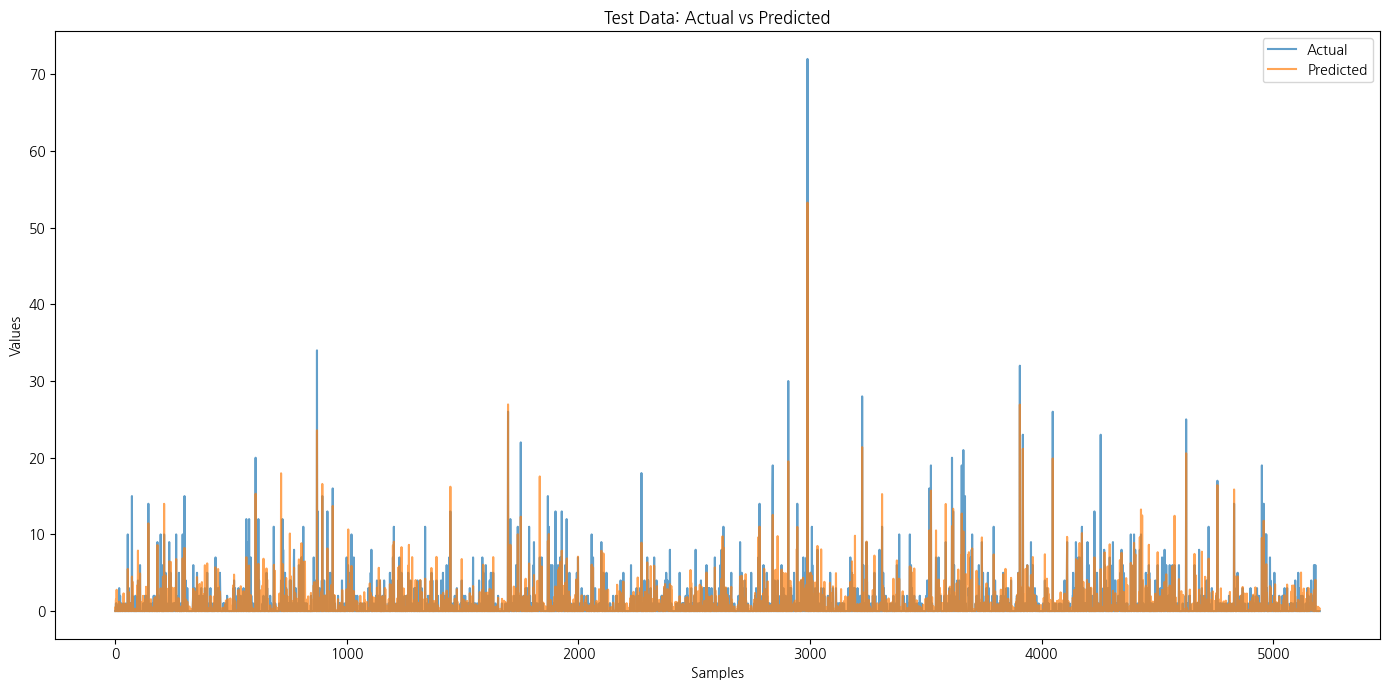

In [10]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(14, 7))

# Test 데이터에 대한 라인차트
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred_test_rf, label='Predicted', alpha=0.7)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

### SIDO별 모델링 (CASE1)

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

sido create_date  sido_cd  weekend_yn  grid_x  grid_y  sat_x  sat_y  \
0   경기도  2014-05-01       31           0      60     120    NaN    NaN   
1  충청북도  2014-05-01       33           0      69     107    NaN    NaN   

   min_ta  max_ta  ...  ta_mean_six_am2  ta_min_six_pm1  ta_max_six_pm1  \
0     9.6    24.2  ...               15              21              24   
1    10.5    23.7  ...               15              21              23   

   ta_mean_six_pm1  ta_min_six_pm2  ta_max_six_pm2  ta_mean_six_pm2  \
0               22              14              21               17   
1               22              15              22               18   

   patientsCnt    instDate    updtDate  
0            0  2024-07-31  2024-07-31  
1            0  2024-07-31  2024-07-31  

[2 rows x 58 columns]

In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features = ['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
            'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
            'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
            'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
            'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target = 'patientsCnt'

In [7]:
len(df)

26010

In [8]:
# 시도별로 테스트 데이터를 0.2 비율로 가져오고 나머지 데이터는 학습 데이터로 사용
test_data_list = []
train_data_list = []
sido_cds = df['sido_cd'].unique()

for sido_cd in sido_cds:
    df_sido = df[df['sido_cd'] == sido_cd]
    df_train, df_test = train_test_split(df_sido, test_size=0.2, random_state=11, shuffle=True)
    test_data_list.append(df_test)
    train_data_list.append(df_train)

# 테스트 데이터와 학습 데이터 합치기
test_data = pd.concat(test_data_list)
train_data = pd.concat(train_data_list)

# 특징과 목표 변수 분리
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 데이터 스케일링
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
print('train_data count: ', len(train_data), '개')
print('test_data count: ', len(test_data), '개')


train_data count:  20808 개
test_data count:  5202 개


In [10]:
# RandomForest 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(random_state=11)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=11, ...)

In [11]:
dt_map = {'39': '제주특별자치도', '32': '강원특별자치도', '25': '대전광역시','21': '부산광역시',
    '24': '광주광역시','26': '울산광역시', '38': '경상남도','23': '인천광역시',
    '31': '경기도','33': '충청북도', '22': '대구광역시','35': '전북특별자치도',
    '37': '경상북도','29': '세종특별자치시','36': '전라남도','11': '서울특별시','34': '충청남도'
}

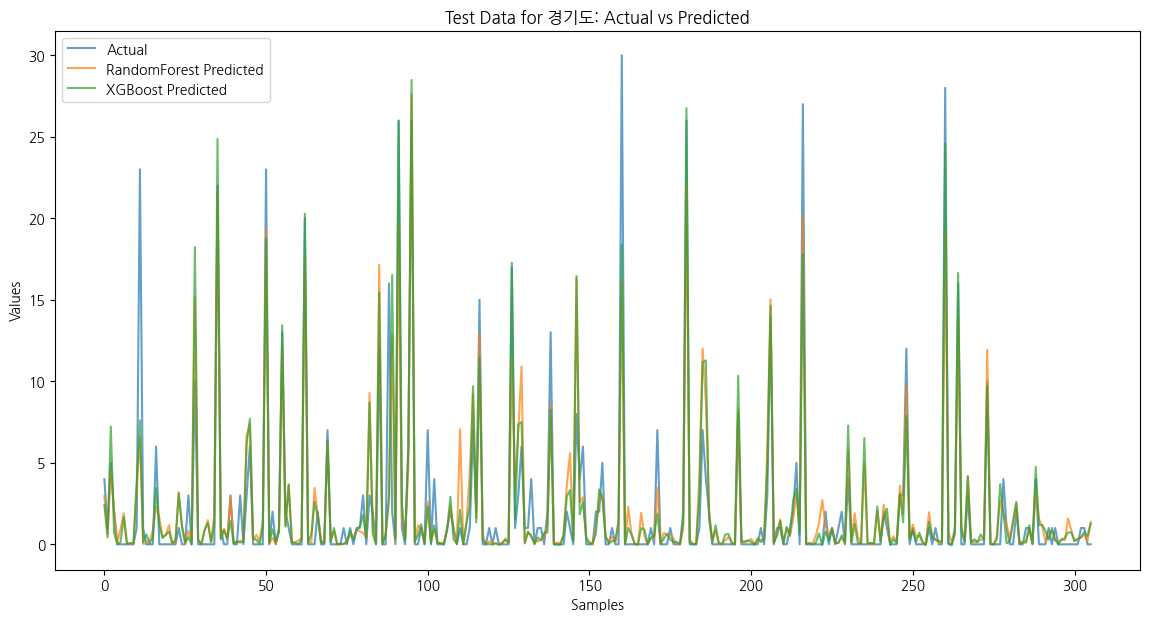

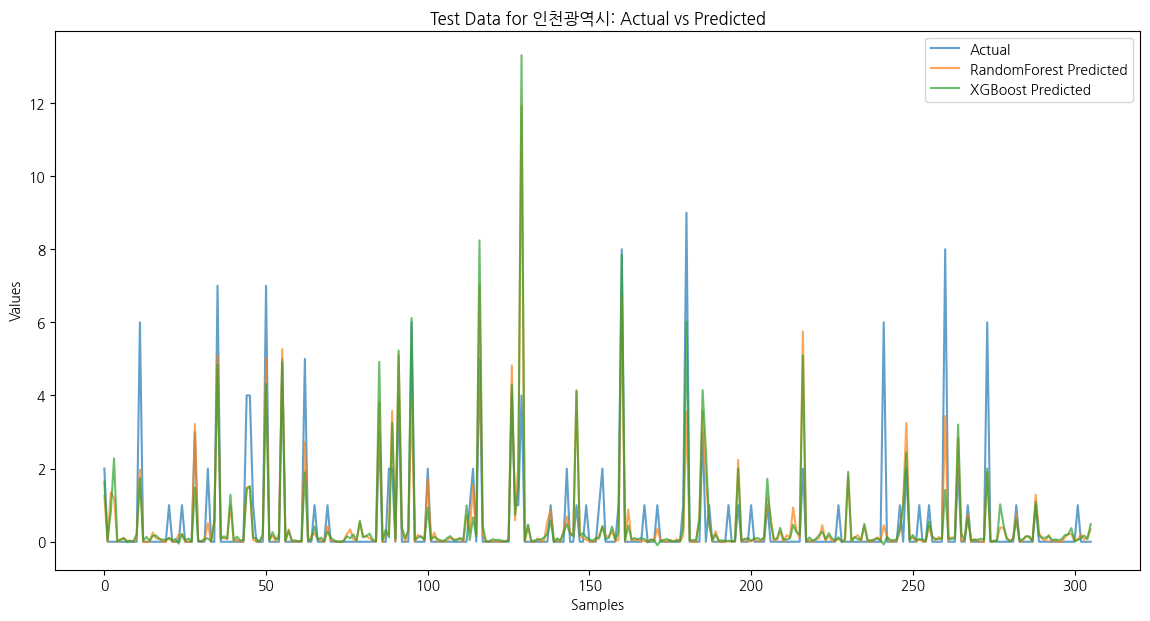

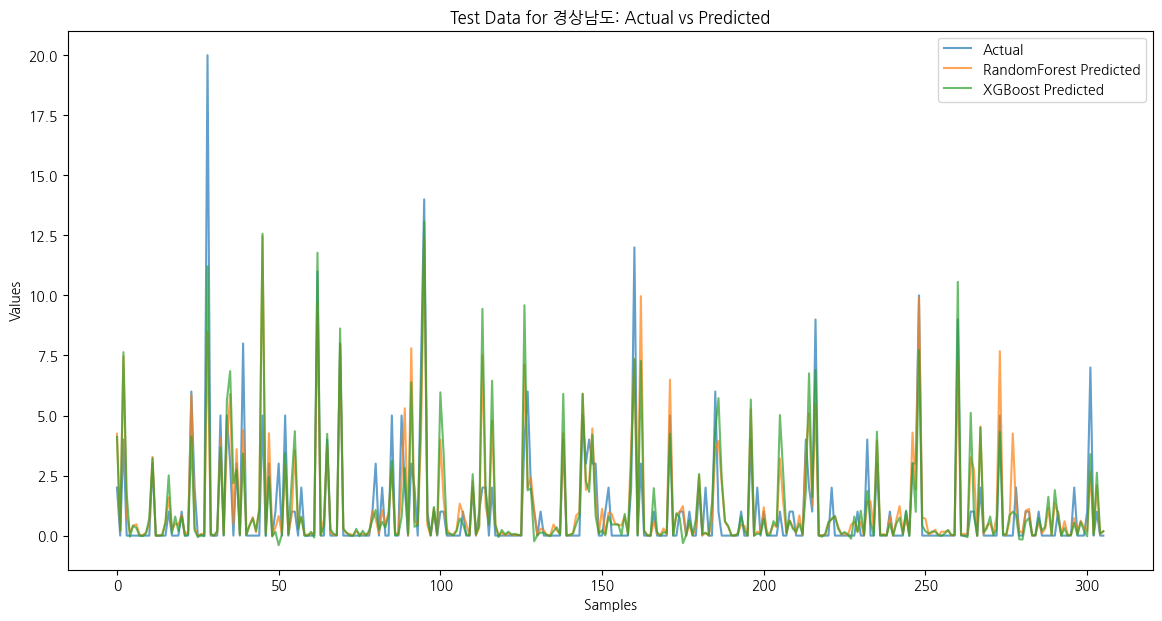

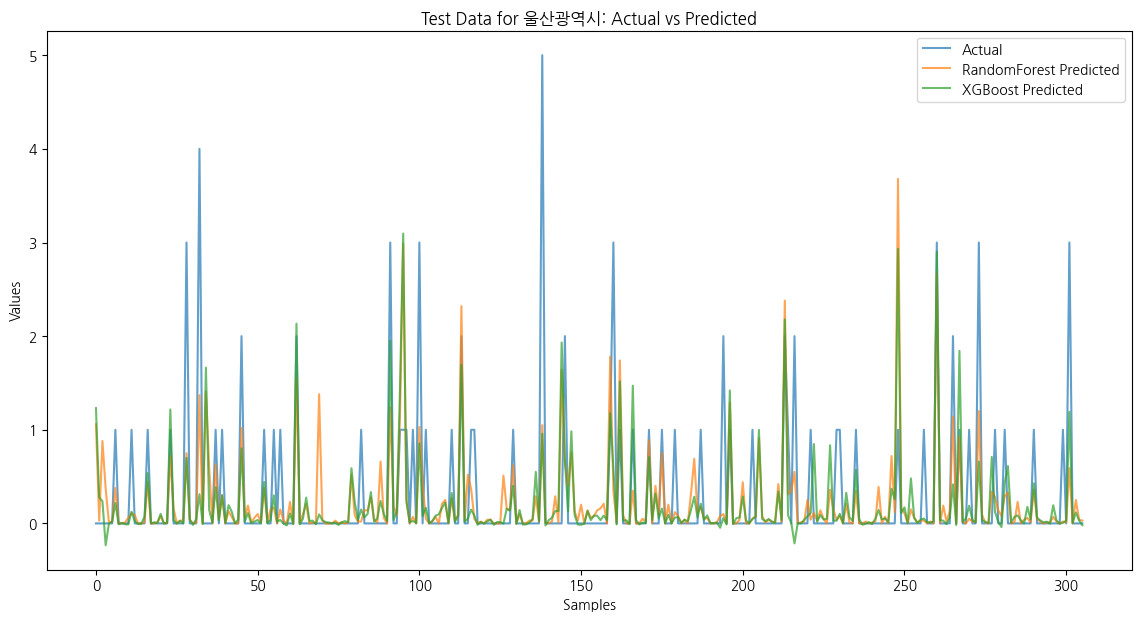

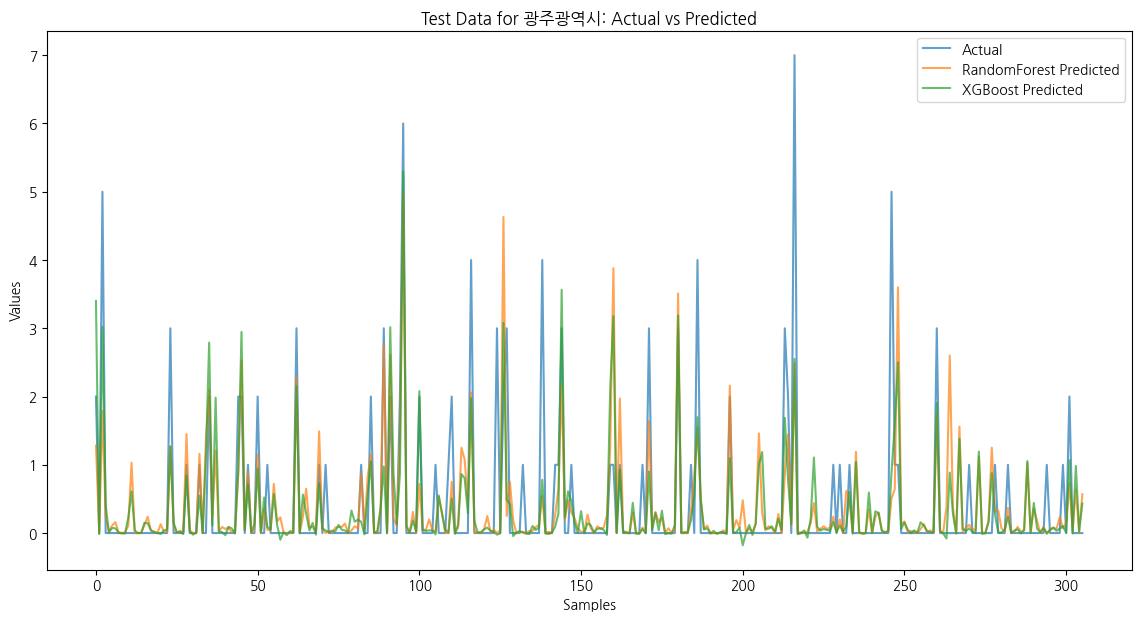

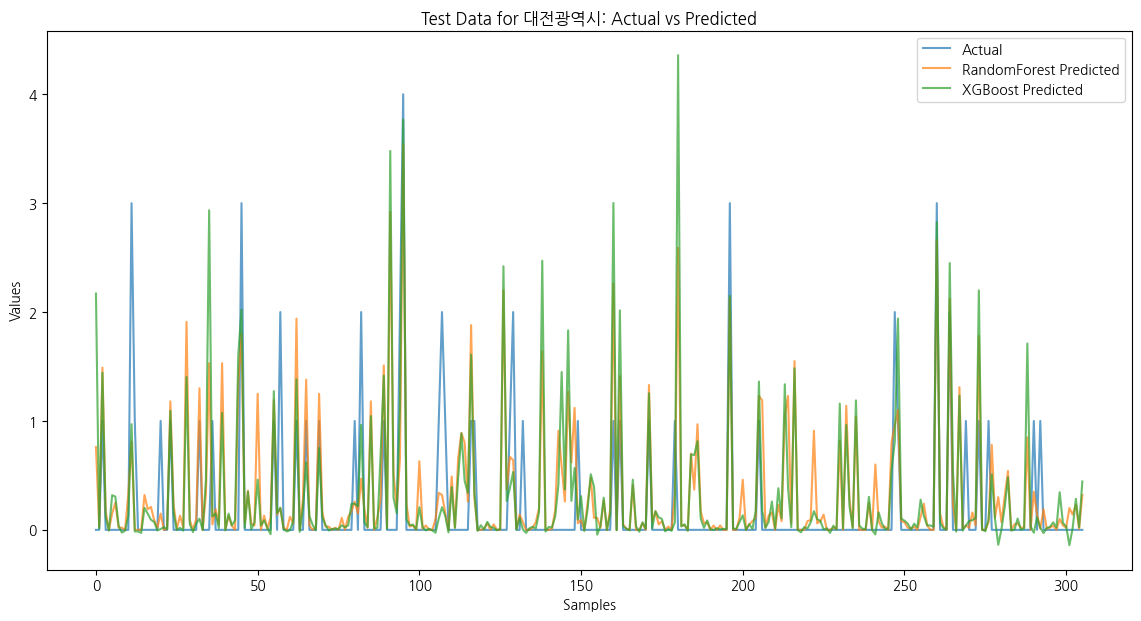

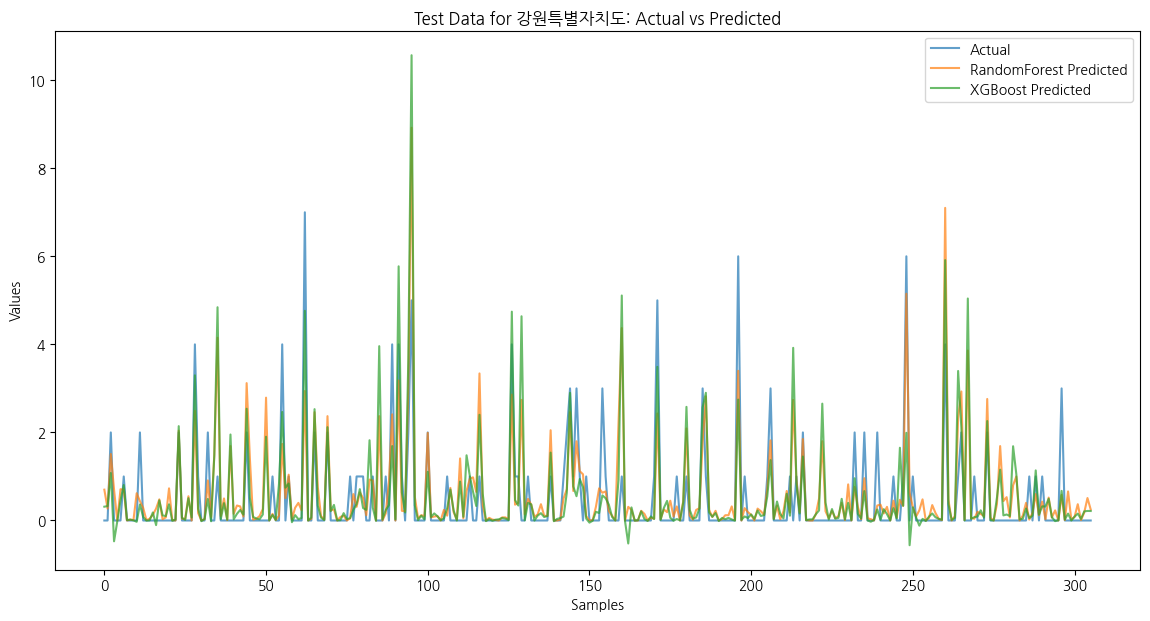

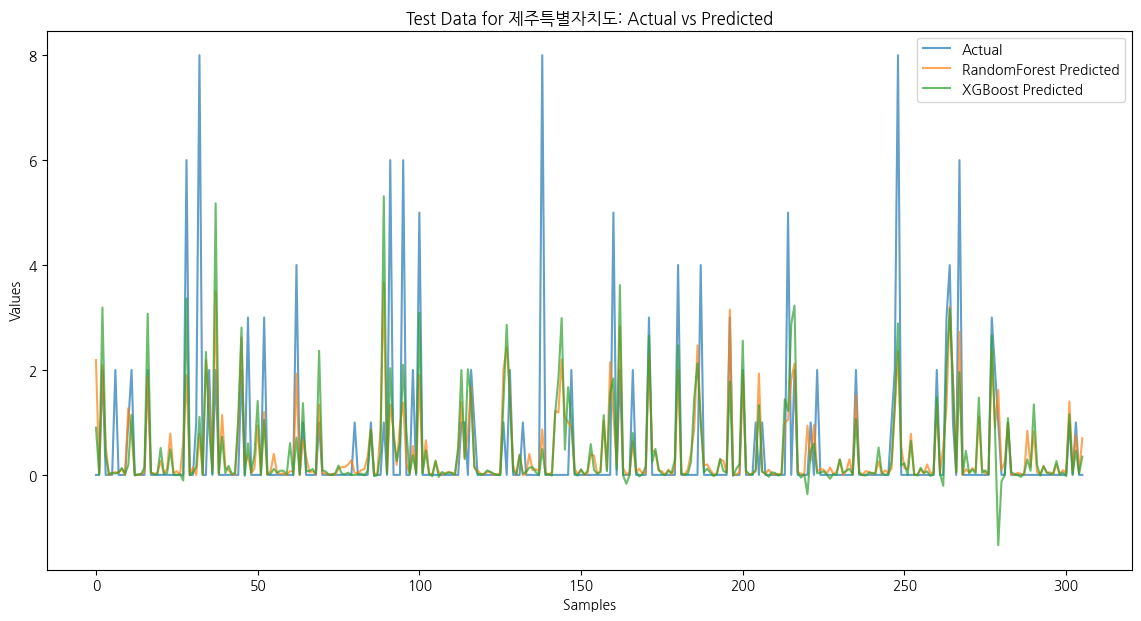

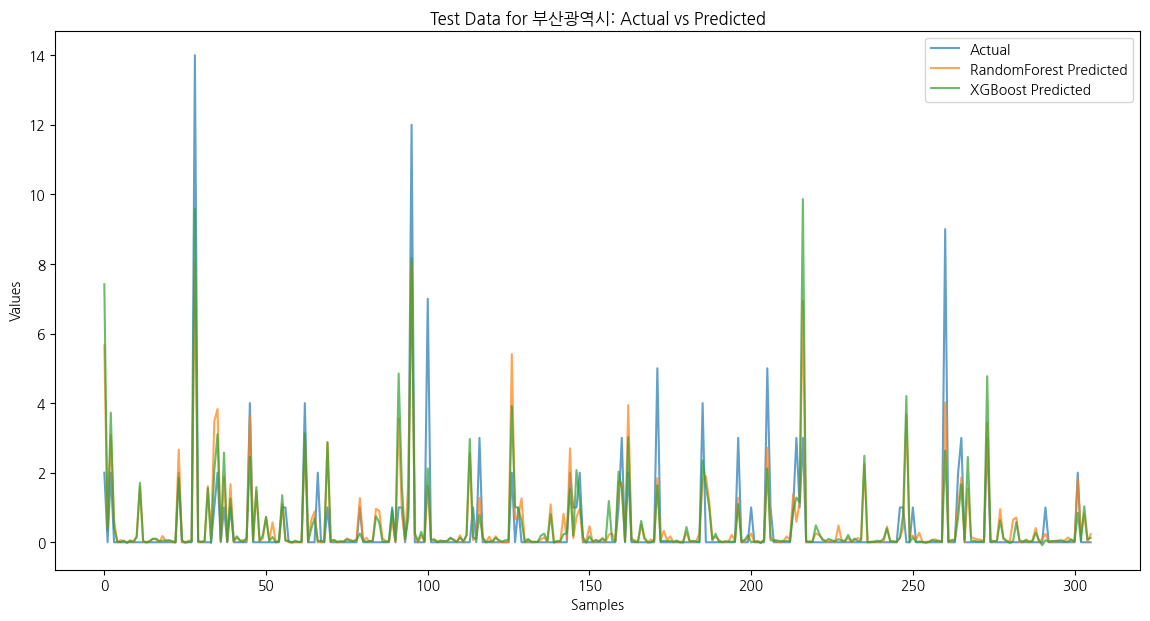

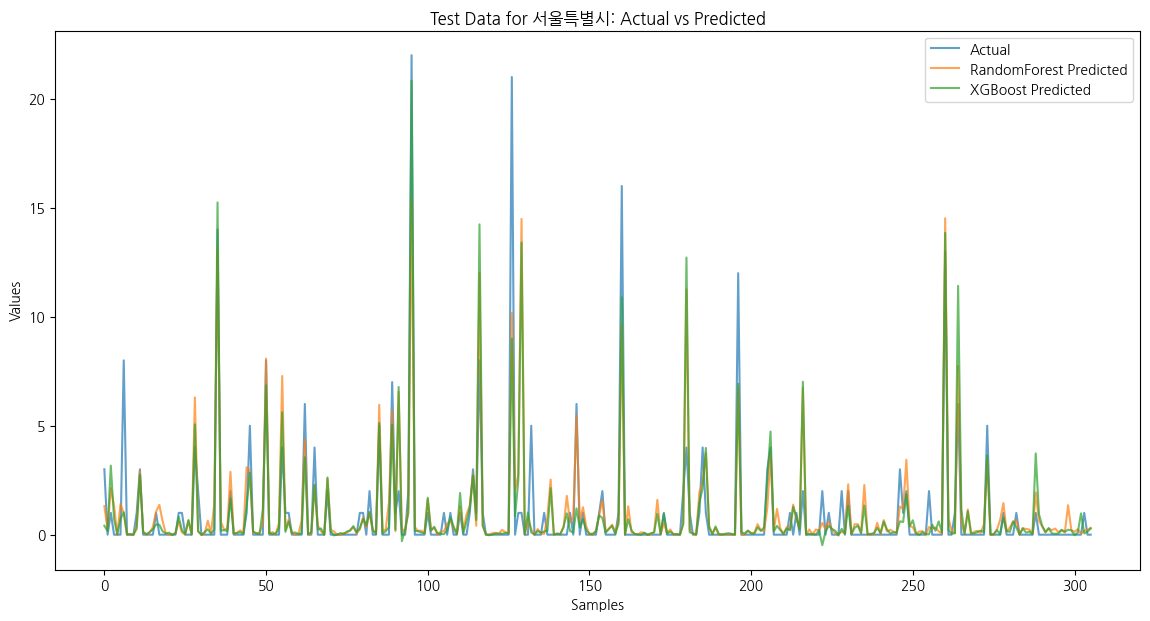

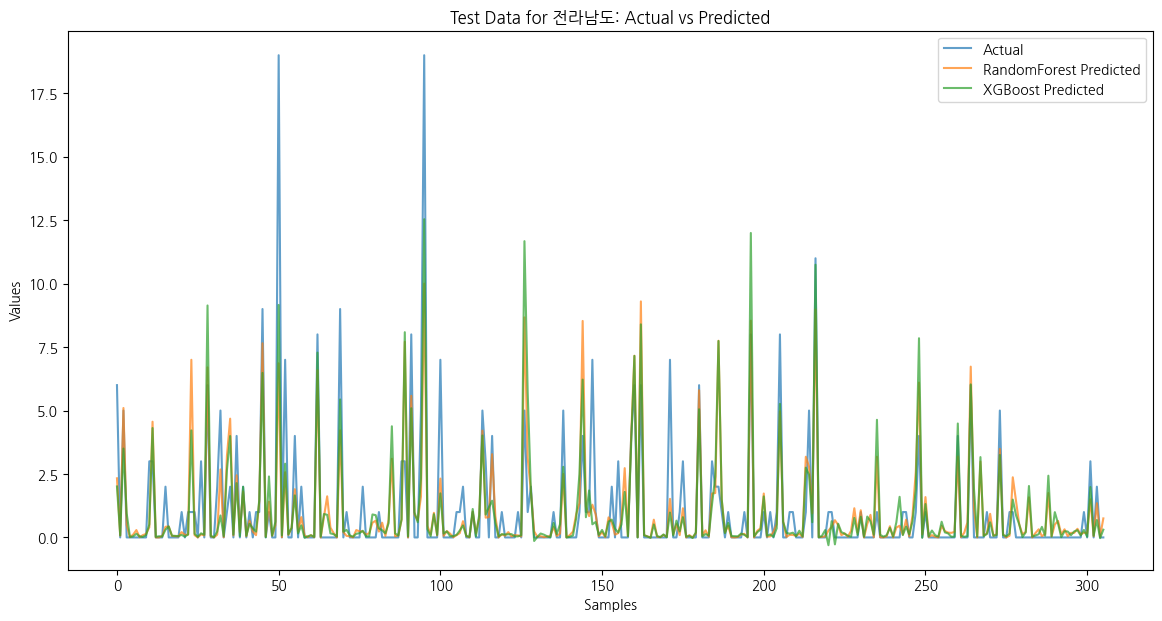

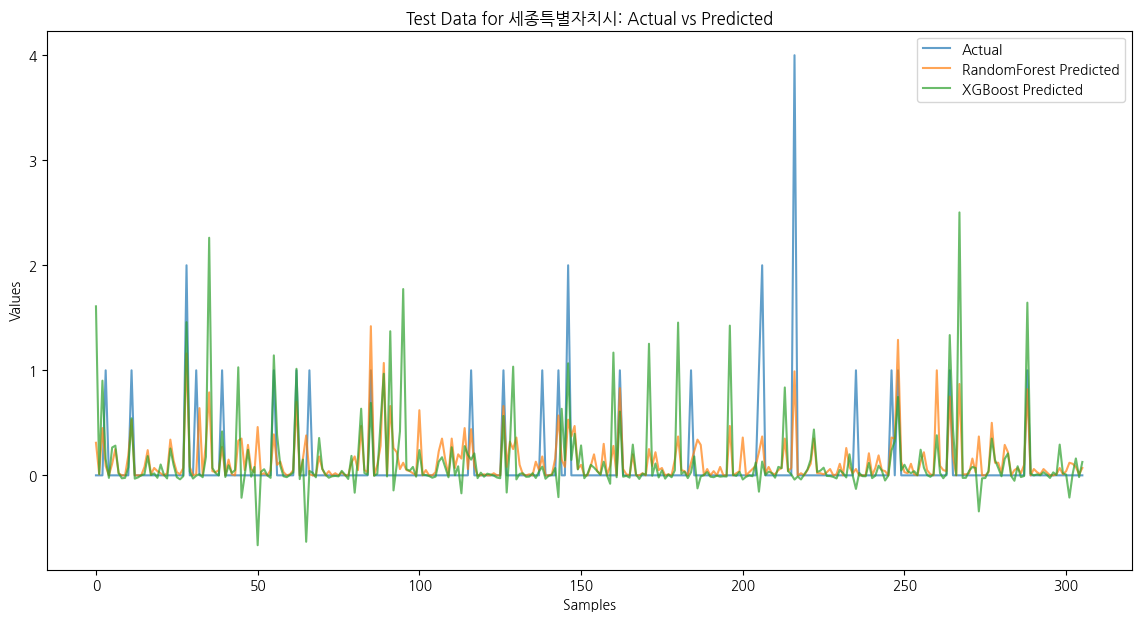

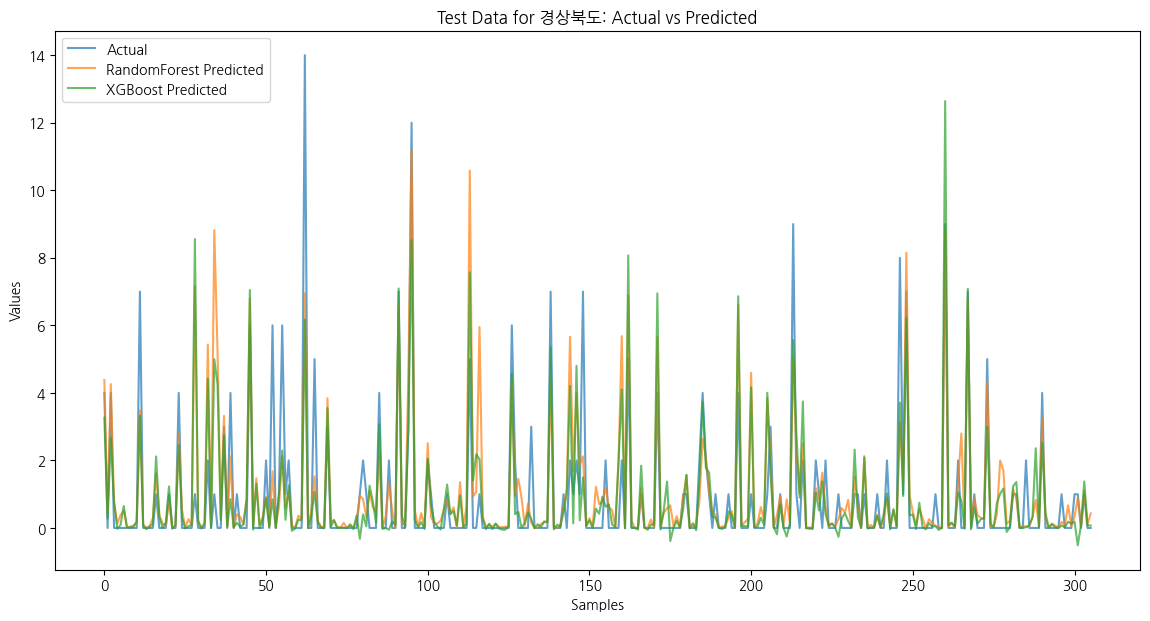

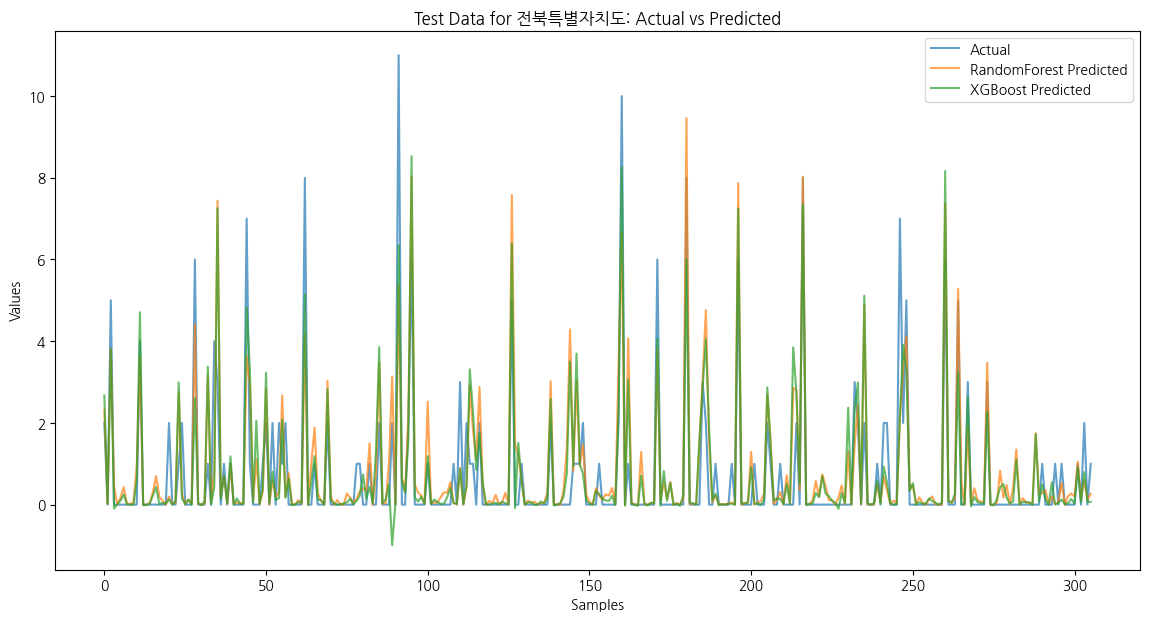

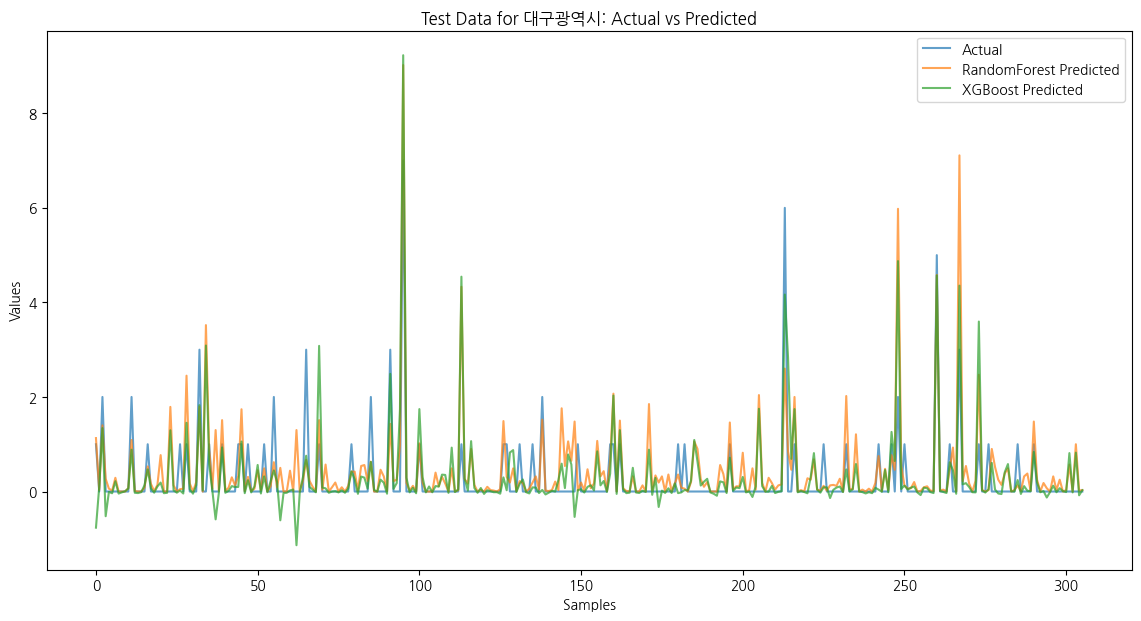

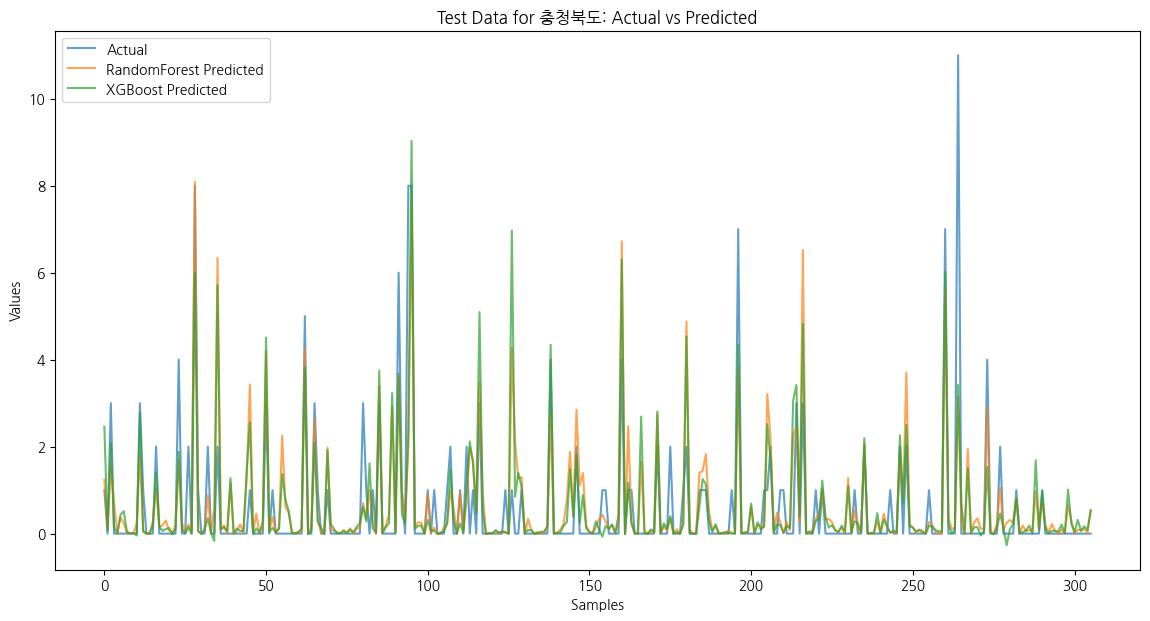

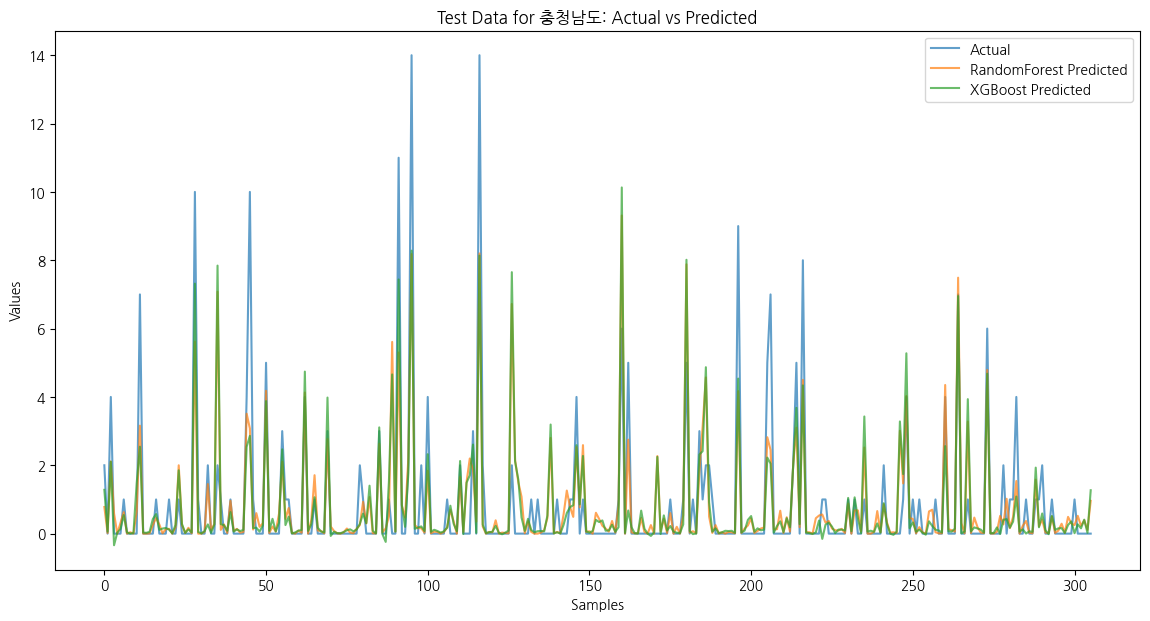


Model: RandomForest
경기도 - MSE: 5.491804575163399, MAE: 1.1523529411764706, R^2: 0.7912287122598938
인천광역시 - MSE: 0.9508718954248367, MAE: 0.39705882352941174, R^2: 0.5340194230447162
경상남도 - MSE: 2.126823202614379, MAE: 0.7368954248366013, R^2: 0.6169369194104035
울산광역시 - MSE: 0.3545450980392157, MAE: 0.2826143790849673, R^2: 0.28748557079389614
광주광역시 - MSE: 0.5894522875816992, MAE: 0.36568627450980395, R^2: 0.4165605606706061
대전광역시 - MSE: 0.32449901960784316, MAE: 0.3072875816993464, R^2: -0.010804730538922058
강원특별자치도 - MSE: 0.7545669934640523, MAE: 0.49062091503267974, R^2: 0.3554585385878489
제주특별자치도 - MSE: 1.2365042483660131, MAE: 0.5011437908496733, R^2: 0.3100698872574724
부산광역시 - MSE: 0.9013565359477125, MAE: 0.40669934640522876, R^2: 0.5709951019910233
서울특별시 - MSE: 2.437638888888889, MAE: 0.6627124183006535, R^2: 0.6501689682126107
전라남도 - MSE: 2.4179264705882355, MAE: 0.7719934640522876, R^2: 0.5919609361623901
세종특별자치시 - MSE: 0.10996895424836602, MAE: 0.1588562091503268, R^2: 0.253

In [12]:
# 시도별 성능 저장 딕셔너리
sido_metrics = {'RandomForest': {}, 'XGBoost': {}}

# 시도별로 실제값과 예측값을 비교하여 MSE, MAE, R^2 계산
for sido_cd in sido_cds:
    df_test_sido = test_data[test_data['sido_cd'] == sido_cd]
    X_test_sido = df_test_sido[features]
    y_test_sido = df_test_sido[target]

    # 데이터 스케일링
    X_test_sido = scaler.transform(X_test_sido)

    # RandomForest 예측
    y_pred_test_rf = rf_model.predict(X_test_sido)

    # XGBoost 예측
    y_pred_test_xgb = xgb_model.predict(X_test_sido)

    # 성능 평가 (RandomForest)
    mse_rf = mean_squared_error(y_test_sido, y_pred_test_rf)
    mae_rf = mean_absolute_error(y_test_sido, y_pred_test_rf)
    r2_rf = r2_score(y_test_sido, y_pred_test_rf)

    sido_metrics['RandomForest'][sido_cd] = {'mse': mse_rf, 'mae': mae_rf, 'r2': r2_rf}

    # 성능 평가 (XGBoost)
    mse_xgb = mean_squared_error(y_test_sido, y_pred_test_xgb)
    mae_xgb = mean_absolute_error(y_test_sido, y_pred_test_xgb)
    r2_xgb = r2_score(y_test_sido, y_pred_test_xgb)

    sido_metrics['XGBoost'][sido_cd] = {'mse': mse_xgb, 'mae': mae_xgb, 'r2': r2_xgb}

    # 시각화
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_sido.reset_index(drop=True), label='Actual', alpha=0.7)
    plt.plot(y_pred_test_rf, label='RandomForest Predicted', alpha=0.7)
    plt.plot(y_pred_test_xgb, label='XGBoost Predicted', alpha=0.7)
    title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
    plt.title(f'Test Data for {title}: Actual vs Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    # plt.savefig(f'{sido_cd}_actual_predict_rf_xgb')
    plt.legend()
    plt.show()

# 시도별 성능 지표 출력
for model_name, metrics_dict in sido_metrics.items():
    print(f"\nModel: {model_name}")
    for sido_cd, metrics in metrics_dict.items():
        title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
        print(f"{title} - MSE: {metrics['mse']}, MAE: {metrics['mae']}, R^2: {metrics['r2']}")

In [13]:
# 성능 지표를 저장할 리스트 초기화
metrics_list = []

# 시도별 성능 지표 저장
for model_name, metrics_dict in sido_metrics.items():
    for sido_cd, metrics in metrics_dict.items():
        title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
        metrics_list.append({
            'Model': model_name,
            'sido_name': title,
            'sido_cd': sido_cd,
            'MSE': metrics['mse'],
            'MAE': metrics['mae'],
            'R2': metrics['r2']
        })

# 리스트를 데이터프레임으로 변환
df_metrics = pd.DataFrame(metrics_list)

df_metrics.to_csv('sido_metrics2.csv', encoding='utf-8-sig', index=False)

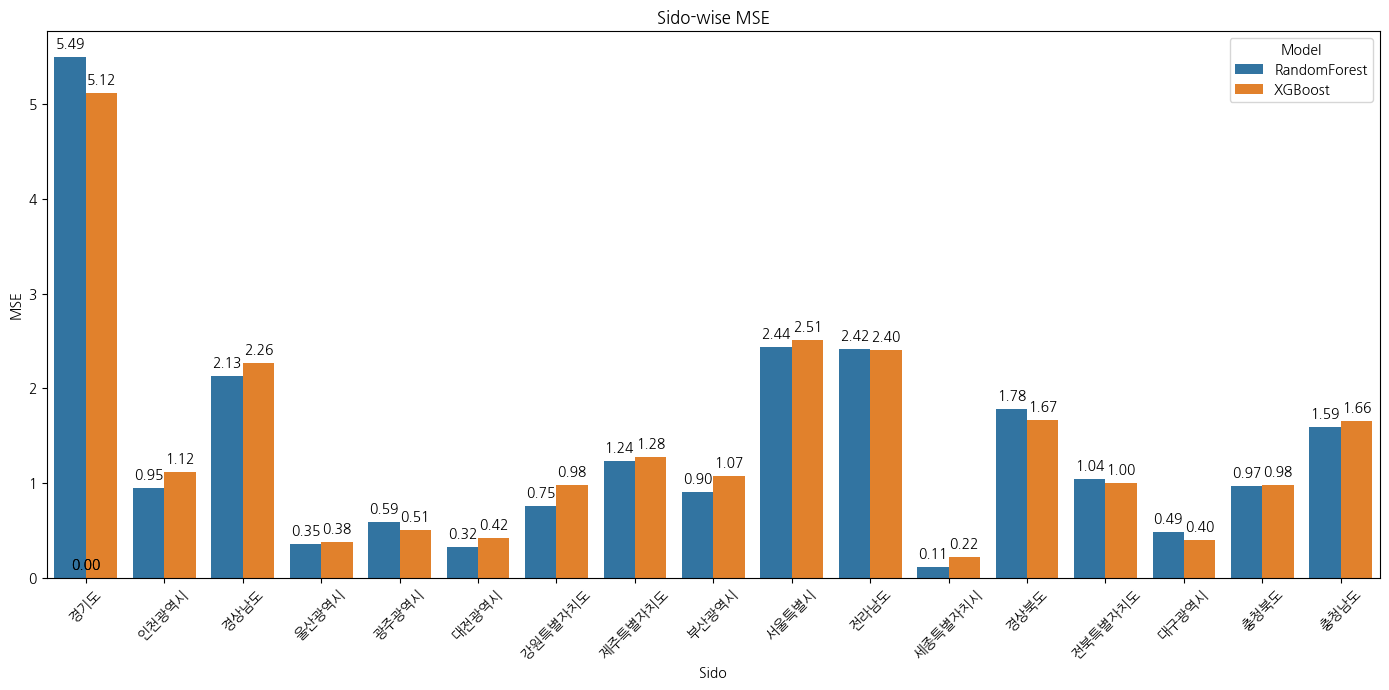

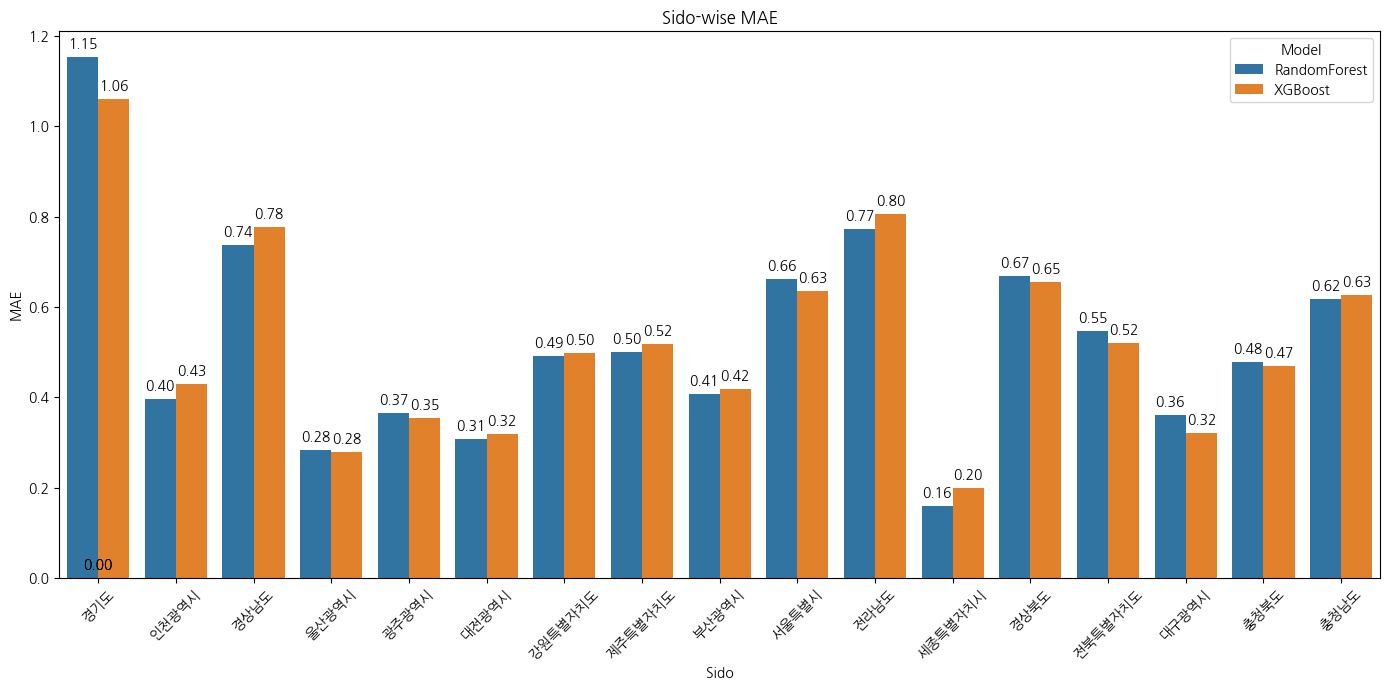

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20716\2924953982.py:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
c:\Users\ecobrain\miniconda3\envs\hwchoi\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


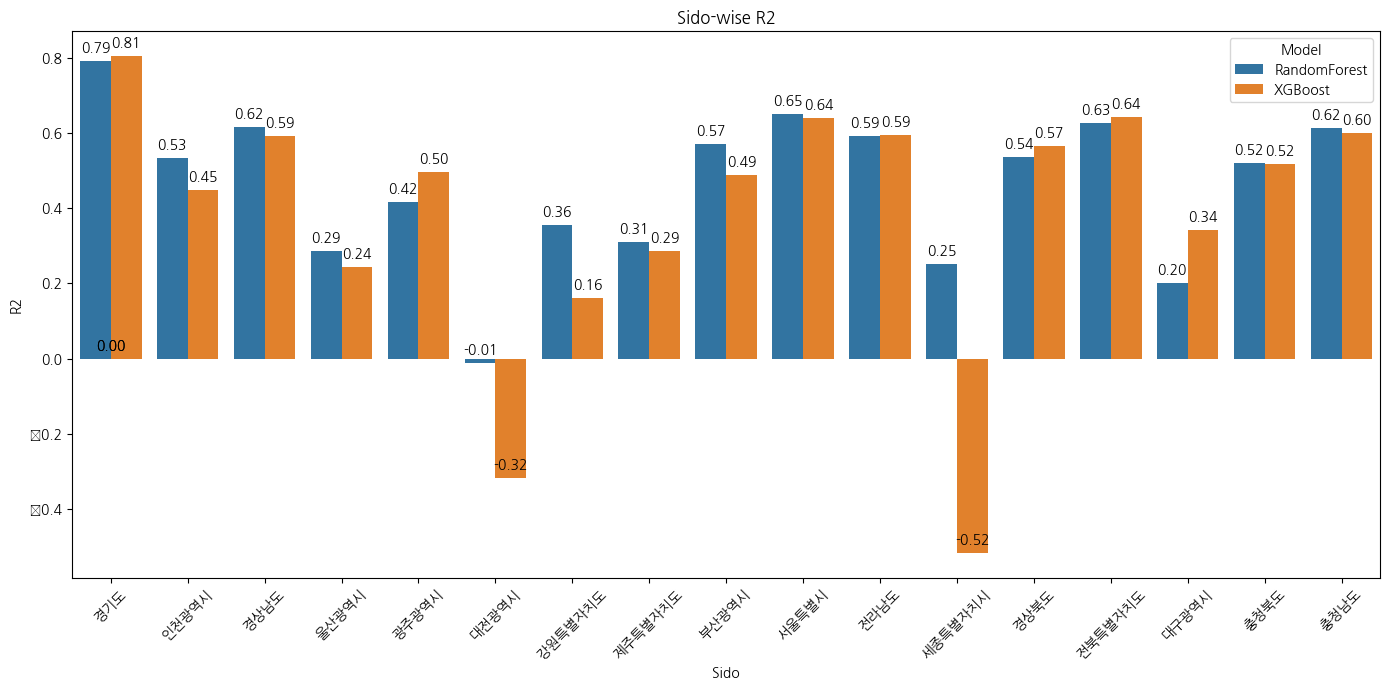

In [17]:
# 시도별 성능 지표 바플롯 시각화
def plot_metrics(df, metric):
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(x='sido_name', y=metric, hue='Model', data=df, errorbar=None)
    plt.title(f'Sido-wise {metric}')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.xlabel('Sido')
    plt.ylabel(metric)
    
    # 바 위에 값 표시
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

# 각 성능 지표에 대해 바플롯 생성
for metric in ['MSE', 'MAE', 'R2']:
    plot_metrics(df_metrics, metric)

### SIDO별 모델링(CASE2)

In [4]:
# 데이터 불러오기
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df = pd.read_csv(path)

In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features = ['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
            'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
            'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
            'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
            'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target = 'patientsCnt'

In [7]:
results = []
predictions = {}

# 시도별로 데이터 분할 및 모델 학습
sido_cds = df['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing Sido: {sido_cd}')
    df_sido_test = df[df['sido_cd'] == sido_cd].sample(frac=0.6, random_state=11)
    print(len(df_sido_test))

    df_train = df[~df.index.isin(df_sido_test.index)]
    df_test = df_sido_test

    # 특징과 목표 변수 분리
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # RandomForest 모델 정의 및 학습
    rf_model = RandomForestRegressor(random_state=11)
    rf_model.fit(X_train, y_train)
    y_pred_test_rf = rf_model.predict(X_test)

    # XGBoost 모델 정의 및 학습
    xgb_model = XGBRegressor(random_state=11)
    xgb_model.fit(X_train, y_train)
    y_pred_test_xgb = xgb_model.predict(X_test)

    # 성능 평가
    models = {
        'RandomForest': y_pred_test_rf,
        'XGBoost': y_pred_test_xgb
    }

    for model_name, y_pred_test in models.items():
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)

        results.append({
            'Sido': sido_cd,
            'Model': model_name,
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        })

        # 예측값과 실제값 저장
        if sido_cd not in predictions:
            predictions[sido_cd] = {}
        predictions[sido_cd][model_name] = (y_test, y_pred_test)

# 결과 데이터프레임으로 변환
df_results = pd.DataFrame(results)
print(df_results)

Processing Sido: 31
918
Processing Sido: 23
918
Processing Sido: 38
918
Processing Sido: 26
918
Processing Sido: 24
918
Processing Sido: 25
918
Processing Sido: 32
918
Processing Sido: 39
918
Processing Sido: 21
918
Processing Sido: 11
918
Processing Sido: 36
918
Processing Sido: 29
918
Processing Sido: 37
918
Processing Sido: 35
918
Processing Sido: 22
918
Processing Sido: 33
918
Processing Sido: 34
918
    Sido         Model       MAE       MSE        R2
0     31  RandomForest  1.266721  8.136947  0.738211
1     31       XGBoost  1.281538  8.783301  0.717416
2     23  RandomForest  0.391416  0.948031  0.525855
3     23       XGBoost  0.411609  0.925569  0.537089
4     38  RandomForest  0.875229  2.731905  0.639273
5     38       XGBoost  0.801634  2.595916  0.657229
6     26  RandomForest  0.280556  0.418206  0.481067
7     26       XGBoost  0.282003  0.436123  0.458835
8     24  RandomForest  0.336917  0.451696  0.475419
9     24       XGBoost  0.344054  0.553557  0.357122
10    25 

In [9]:
# 데이터프레임을 CSV 파일로 저장
df_results.to_csv('sido_model_results.csv', index=False)

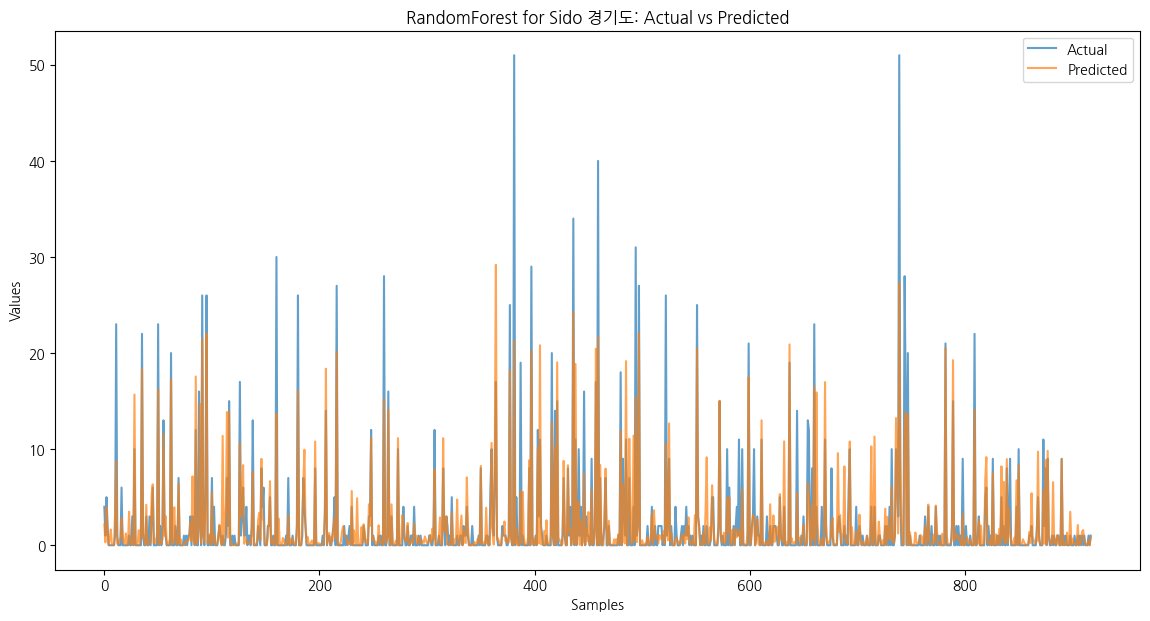

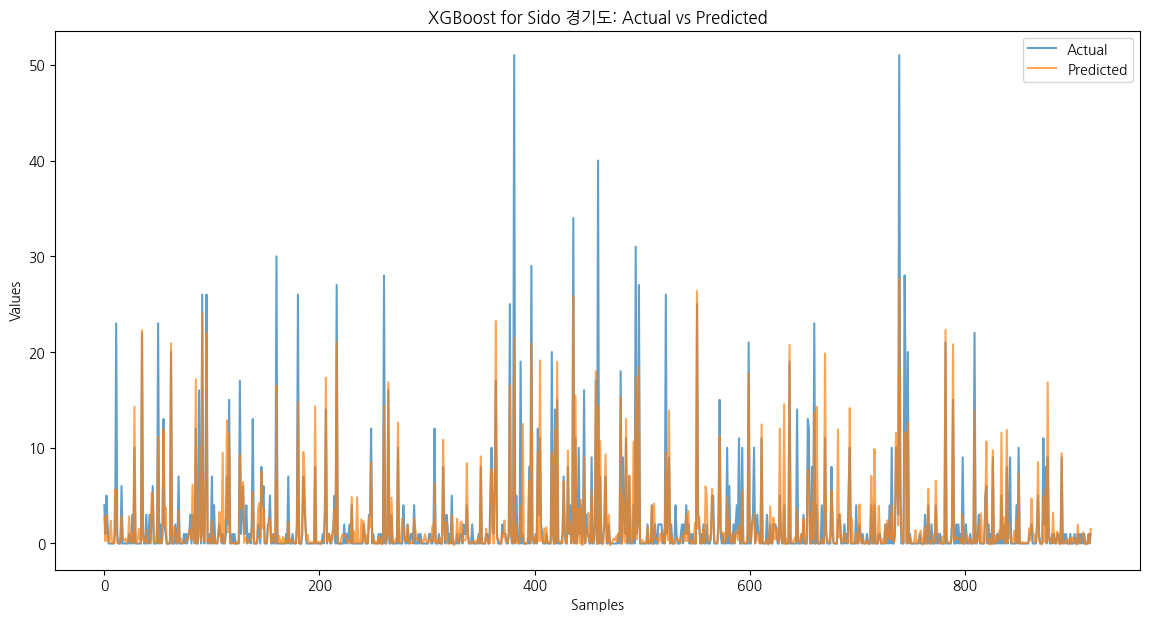

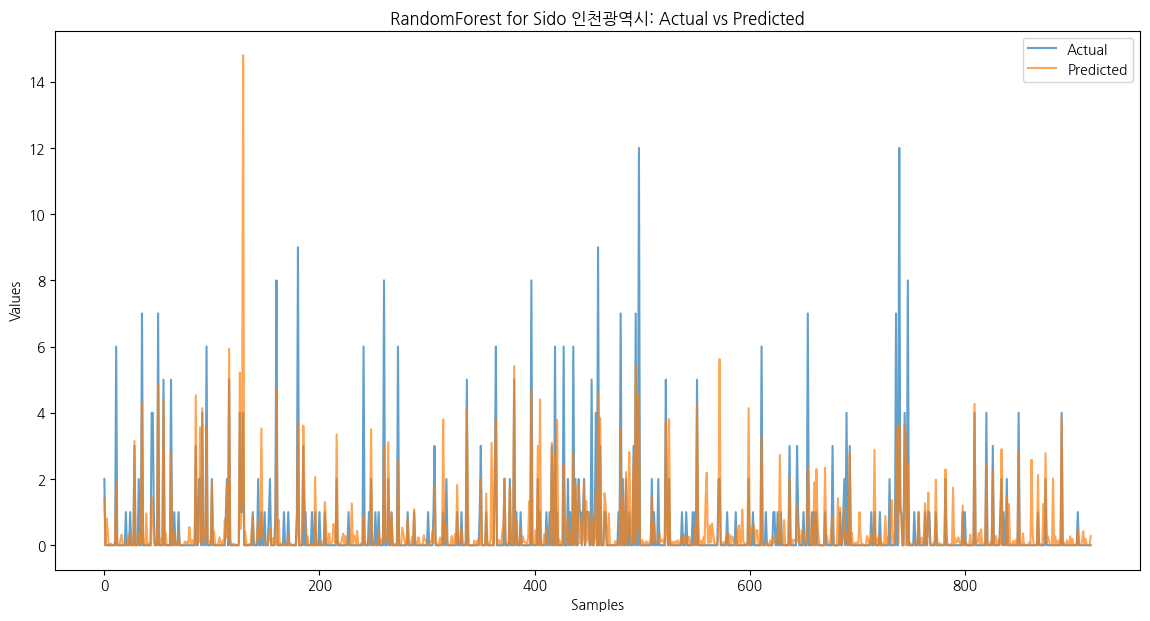

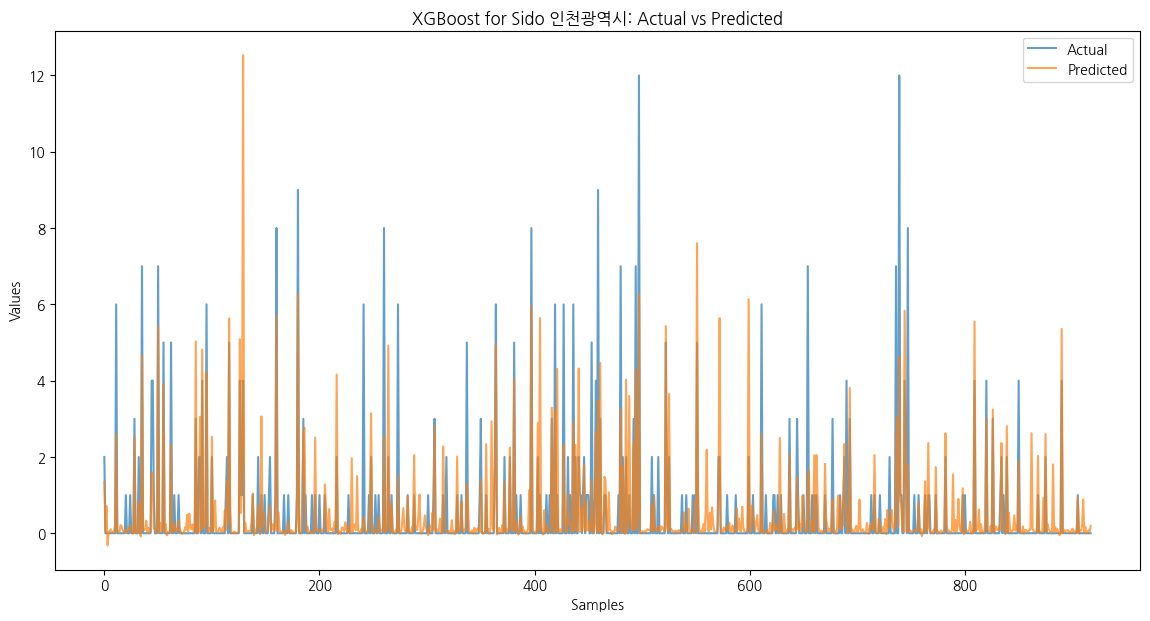

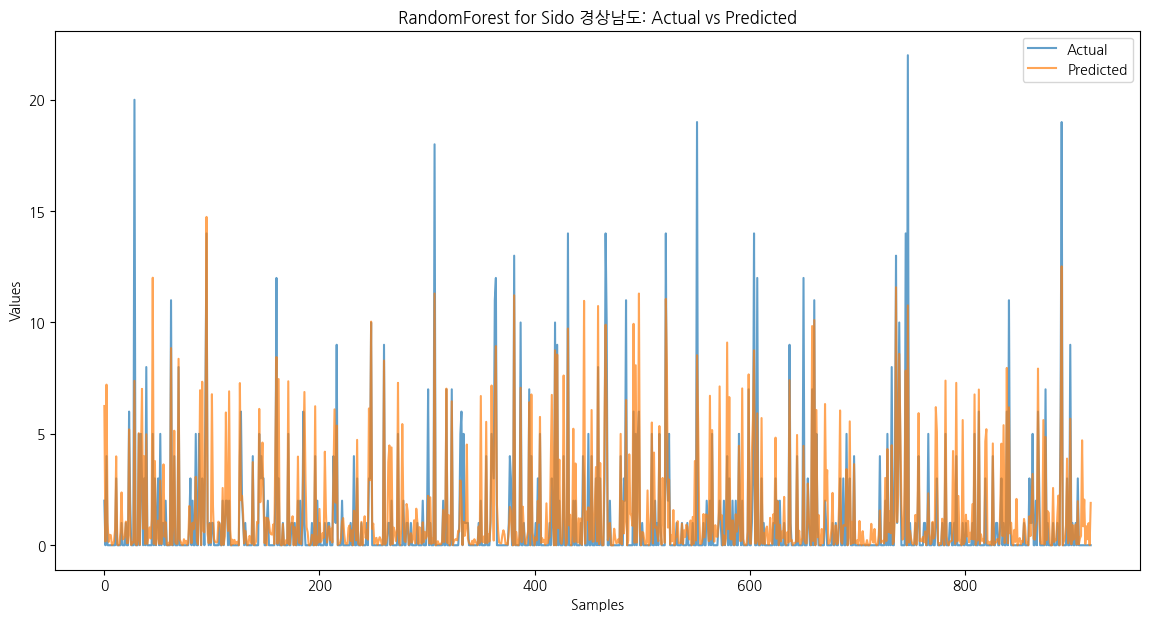

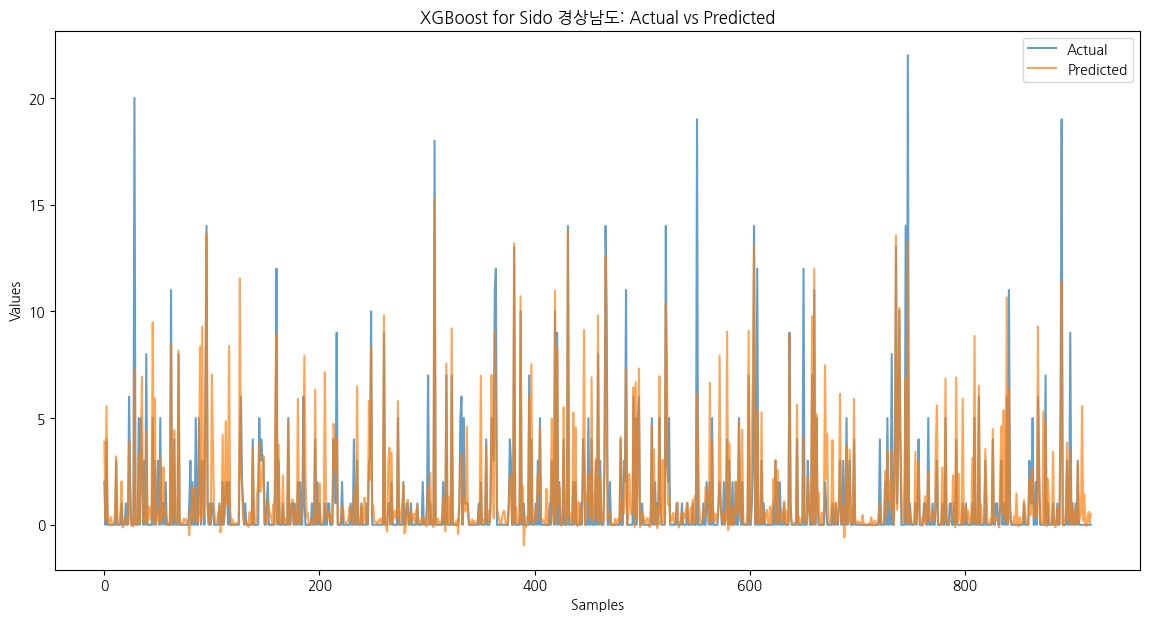

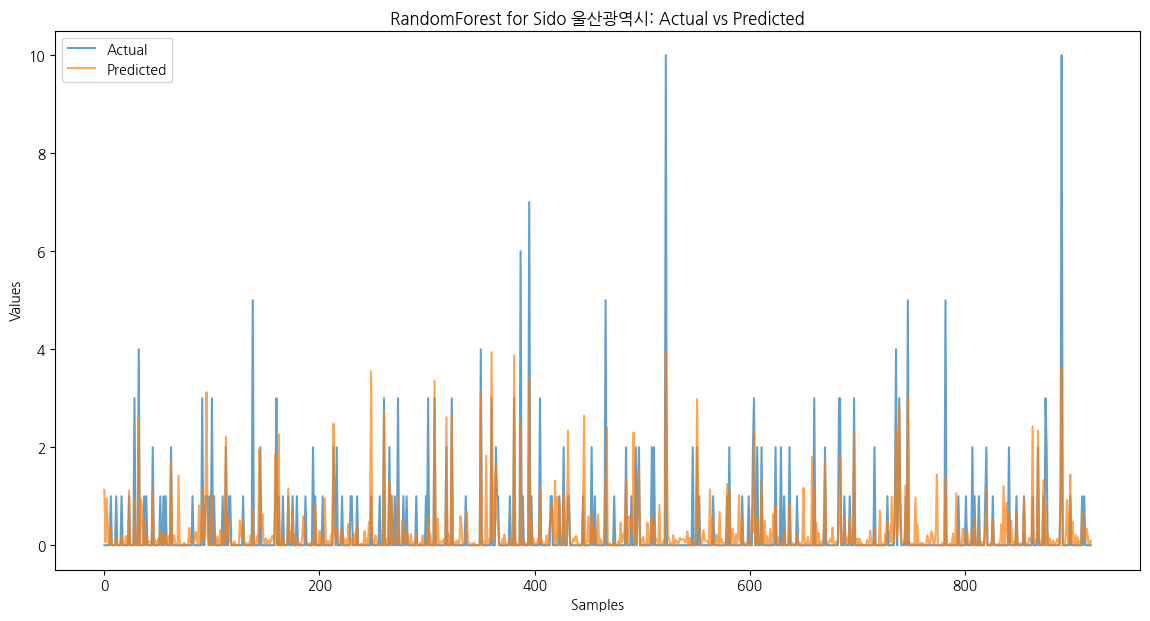

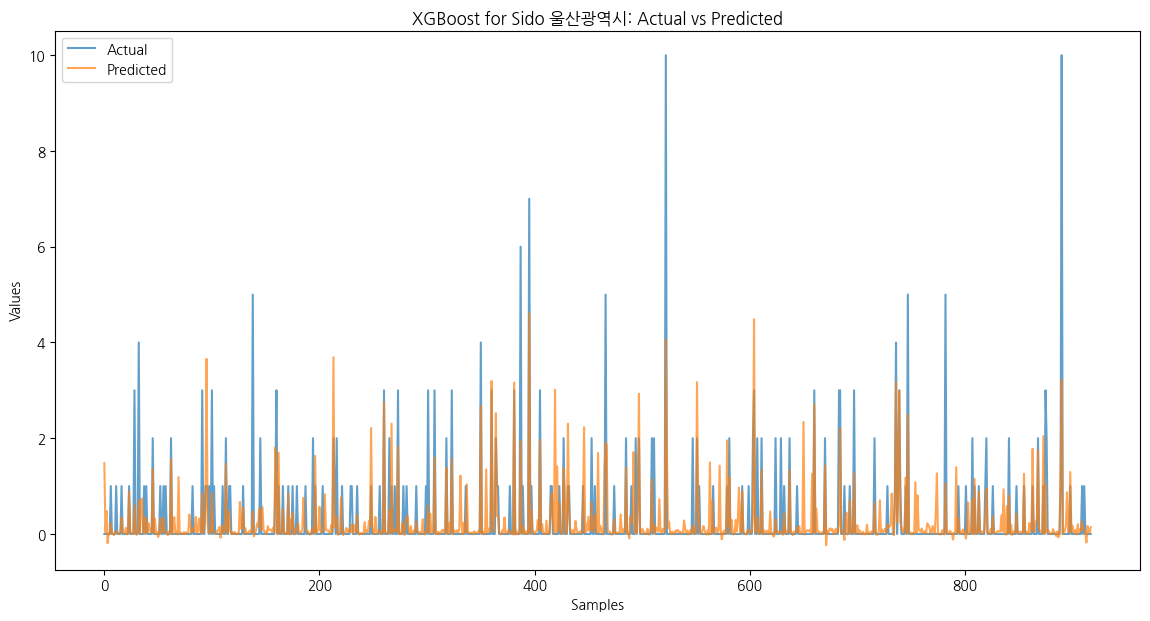

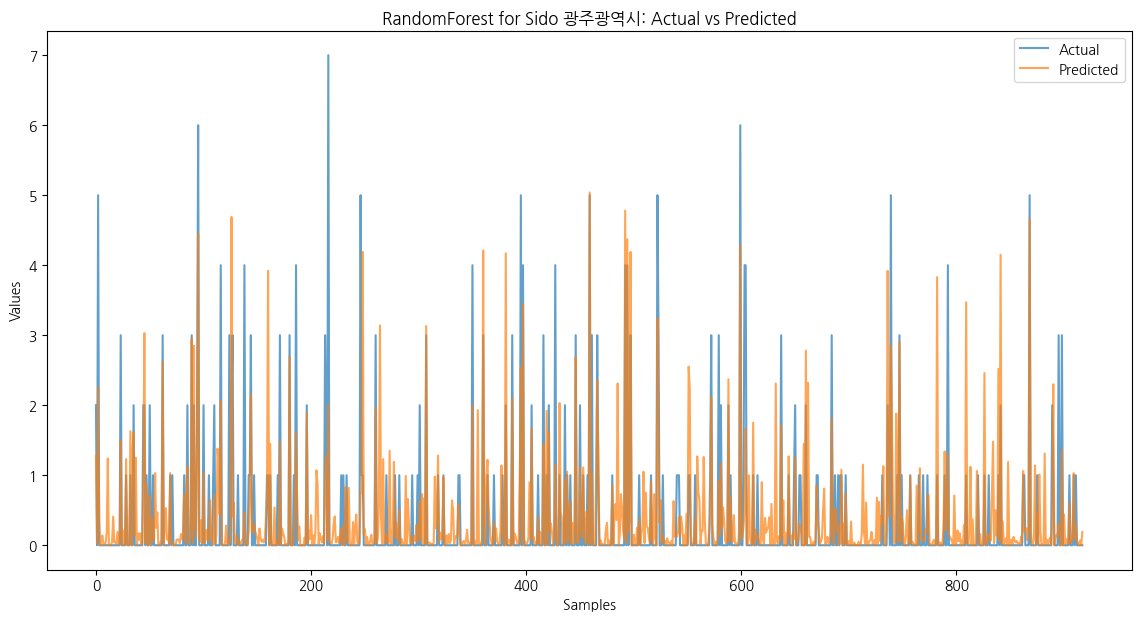

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22364\2696501741.py:15: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'{sido_cd}_actual_predict_rf_xgb')
c:\Users\ecobrain\miniconda3\envs\hwchoi\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


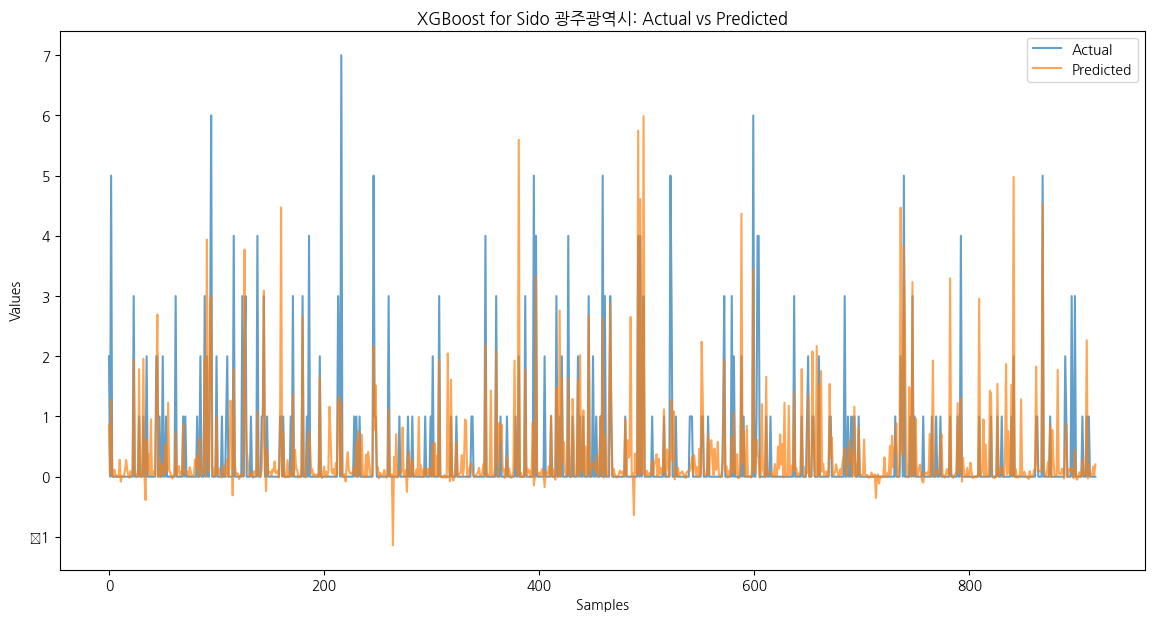

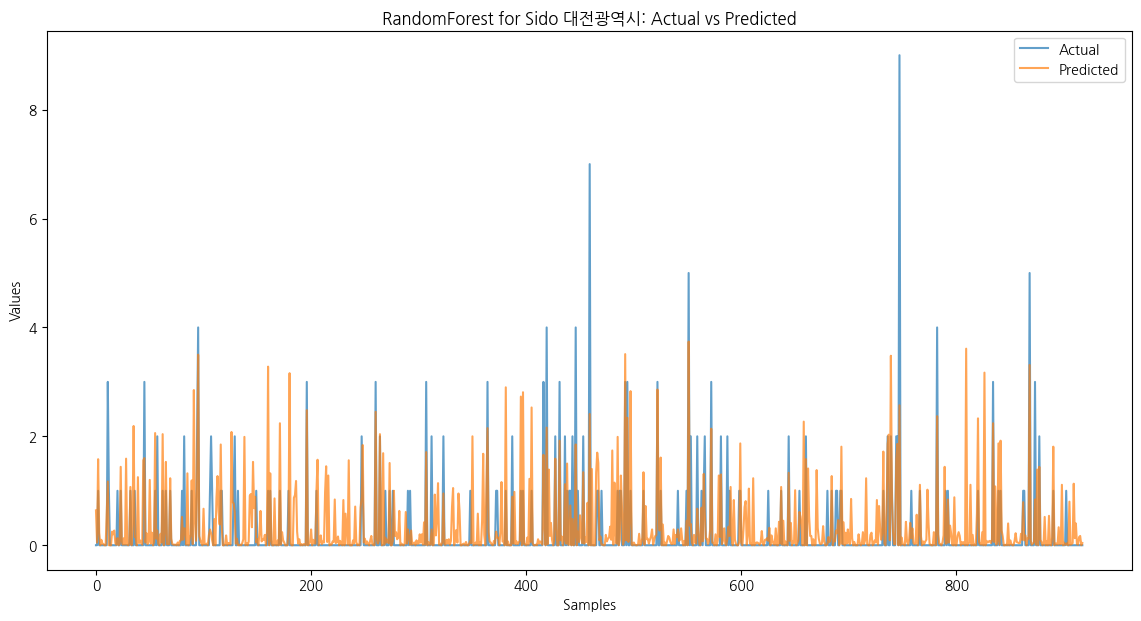

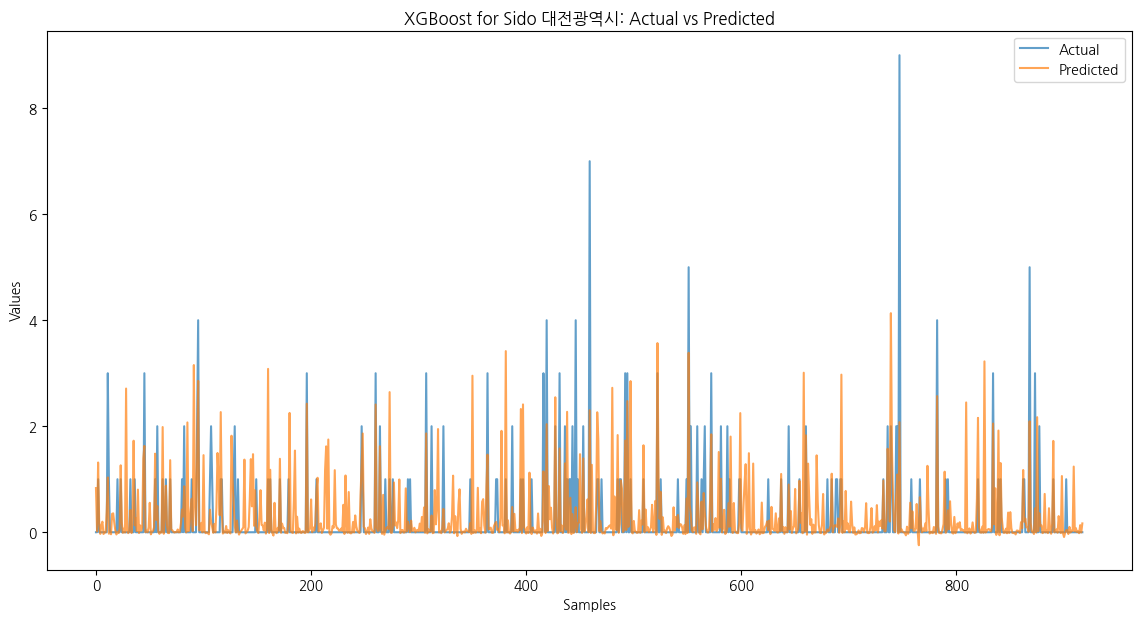

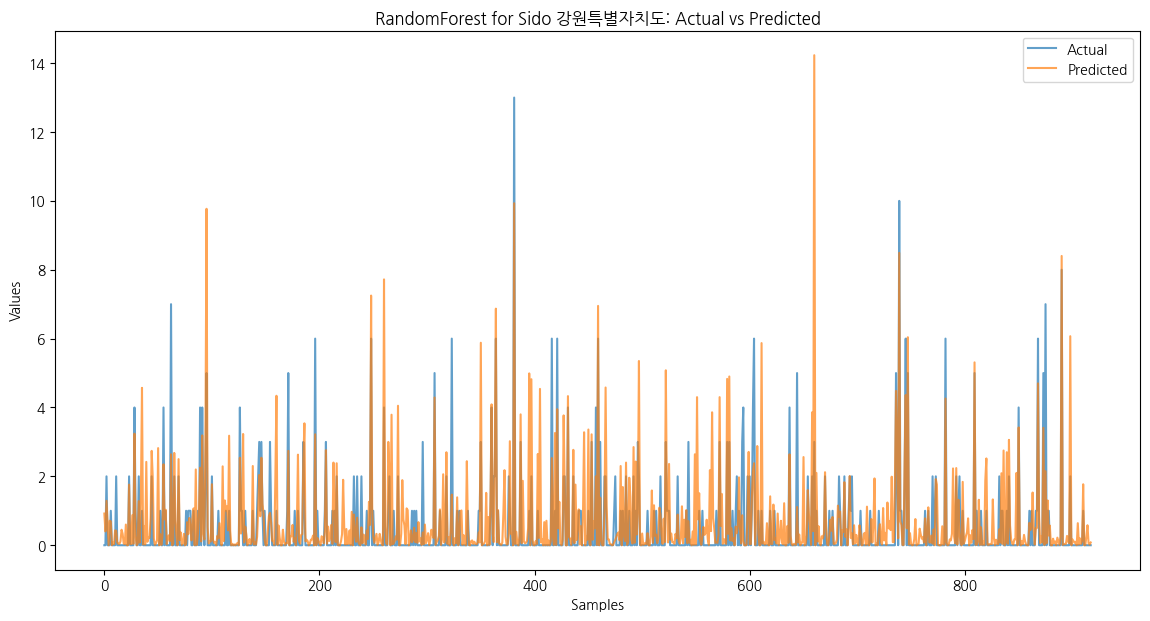

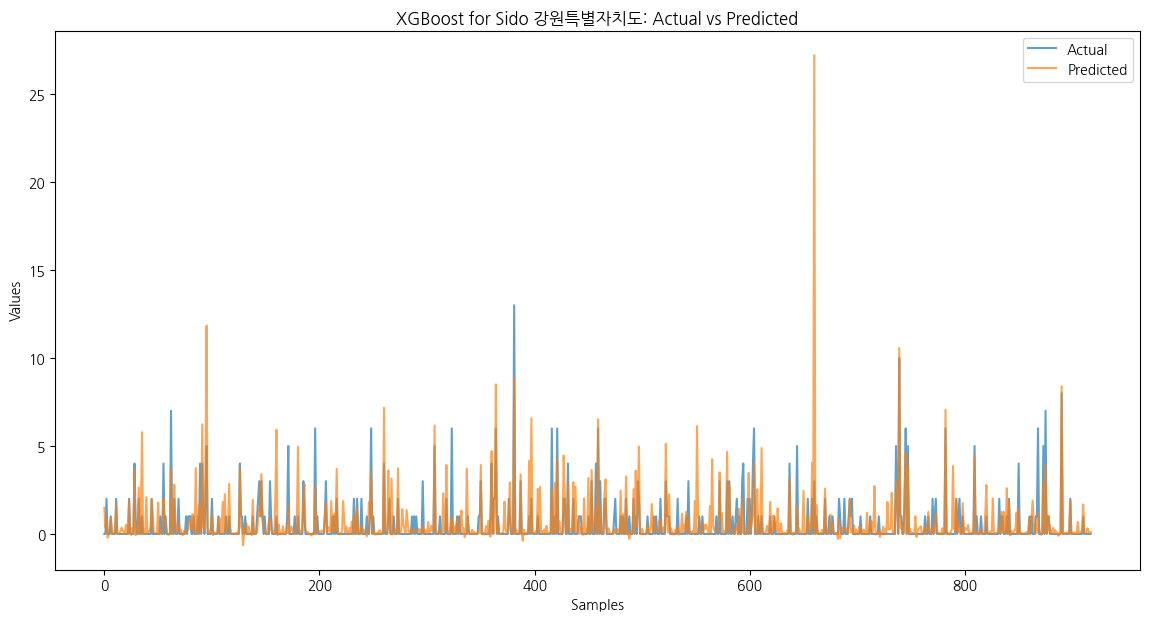

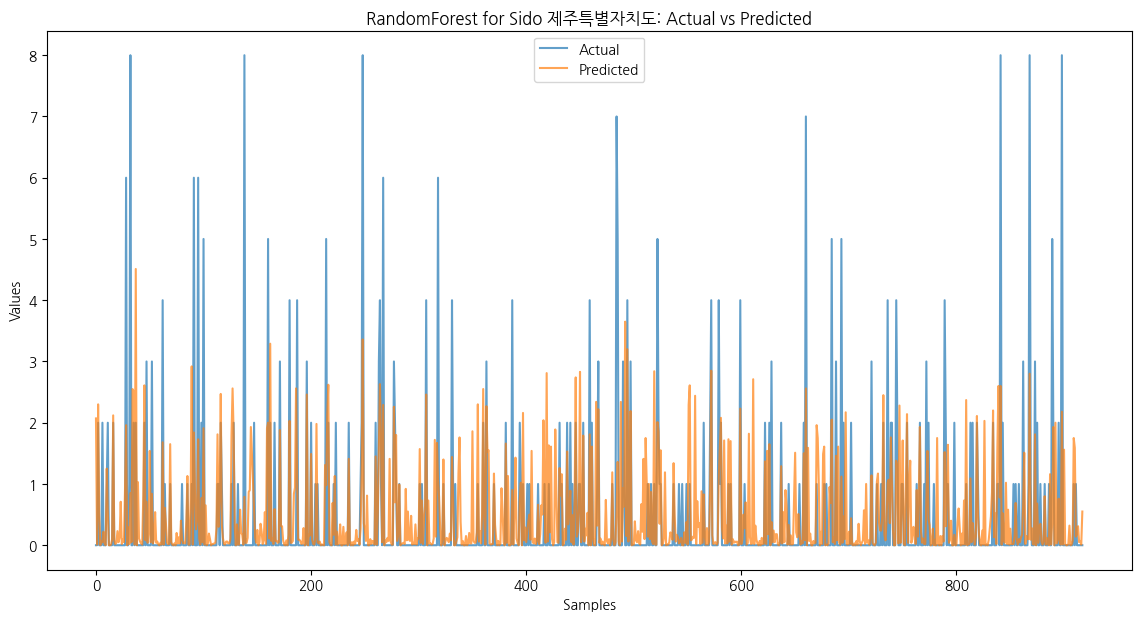

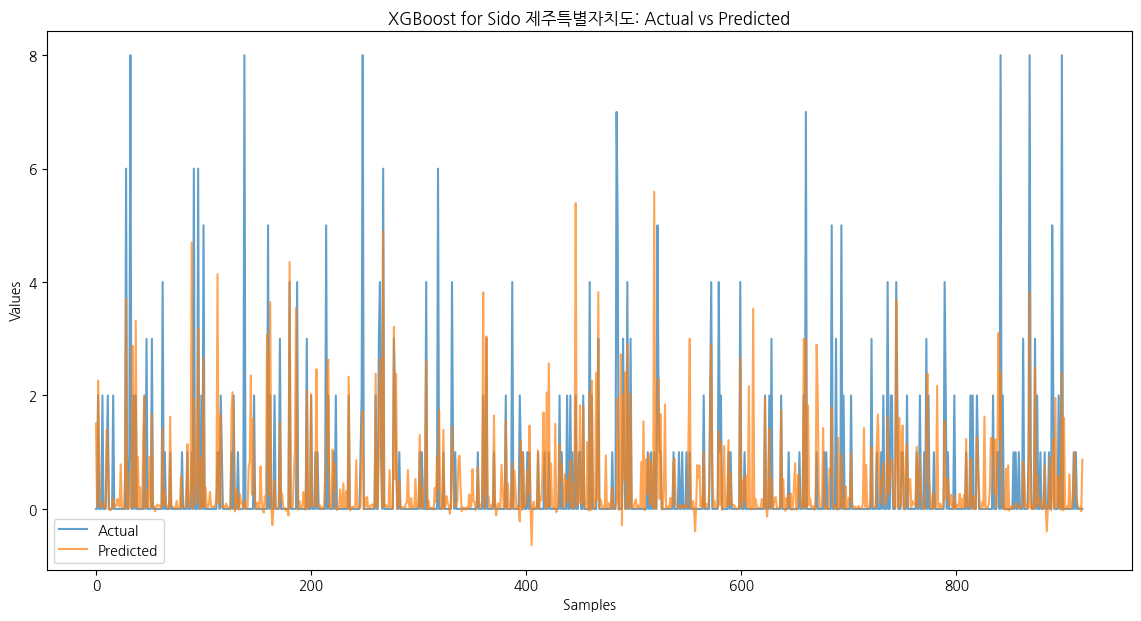

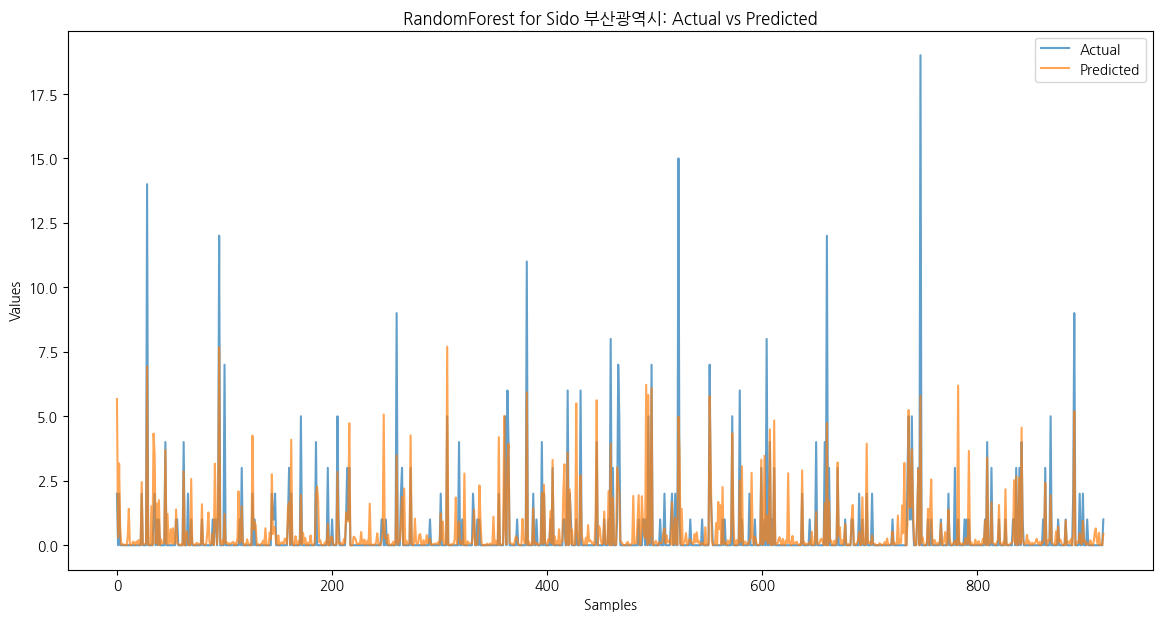

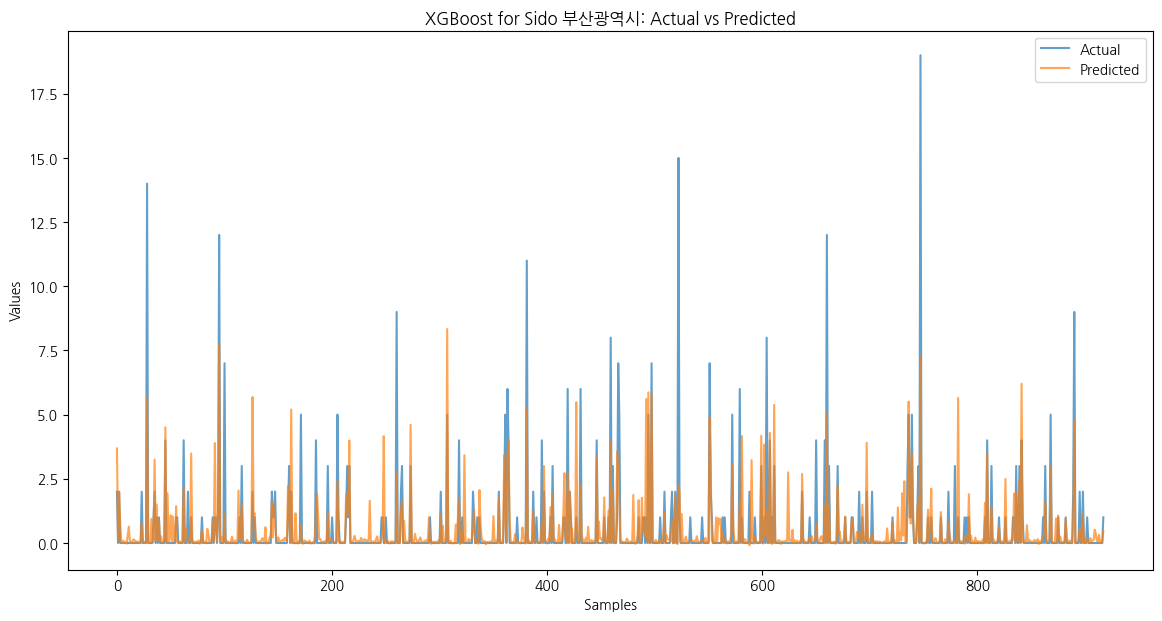

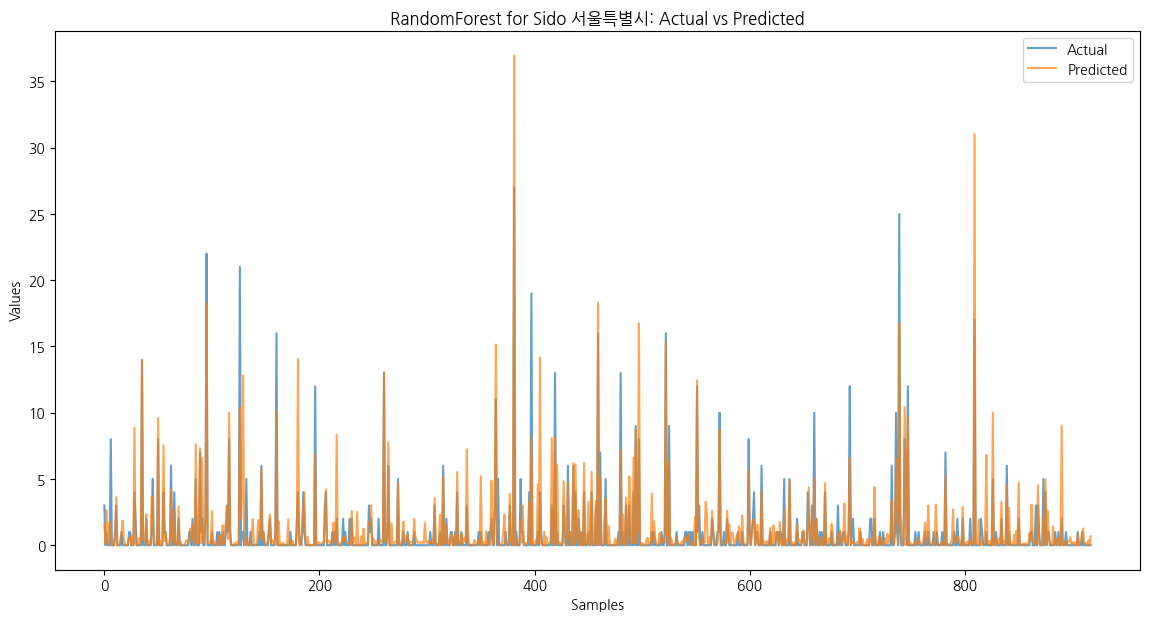

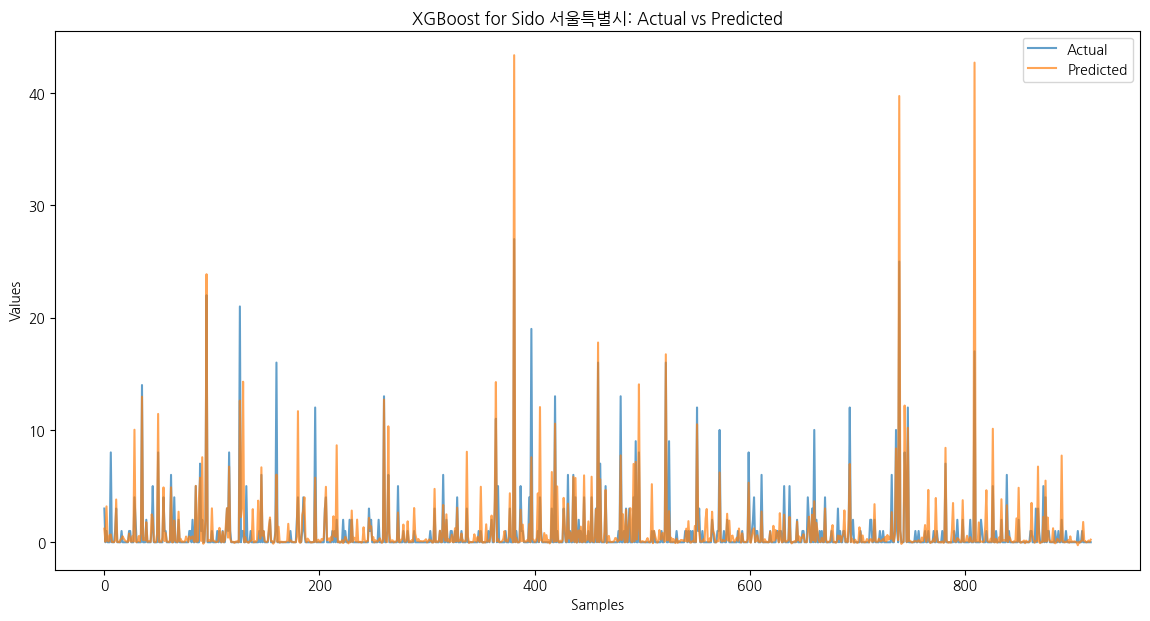

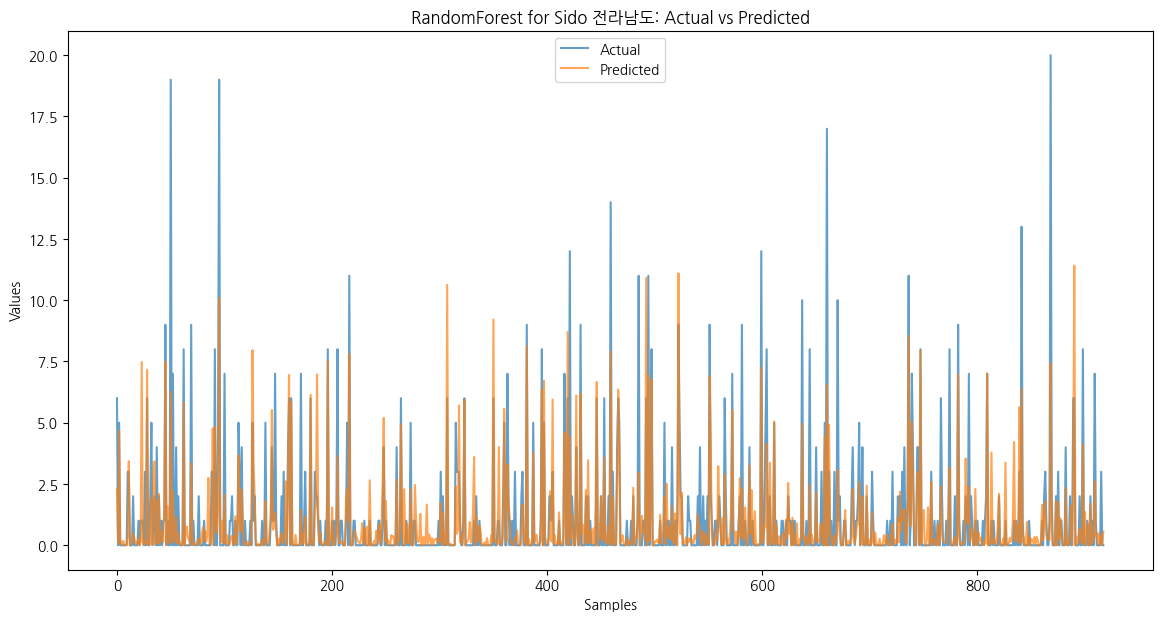

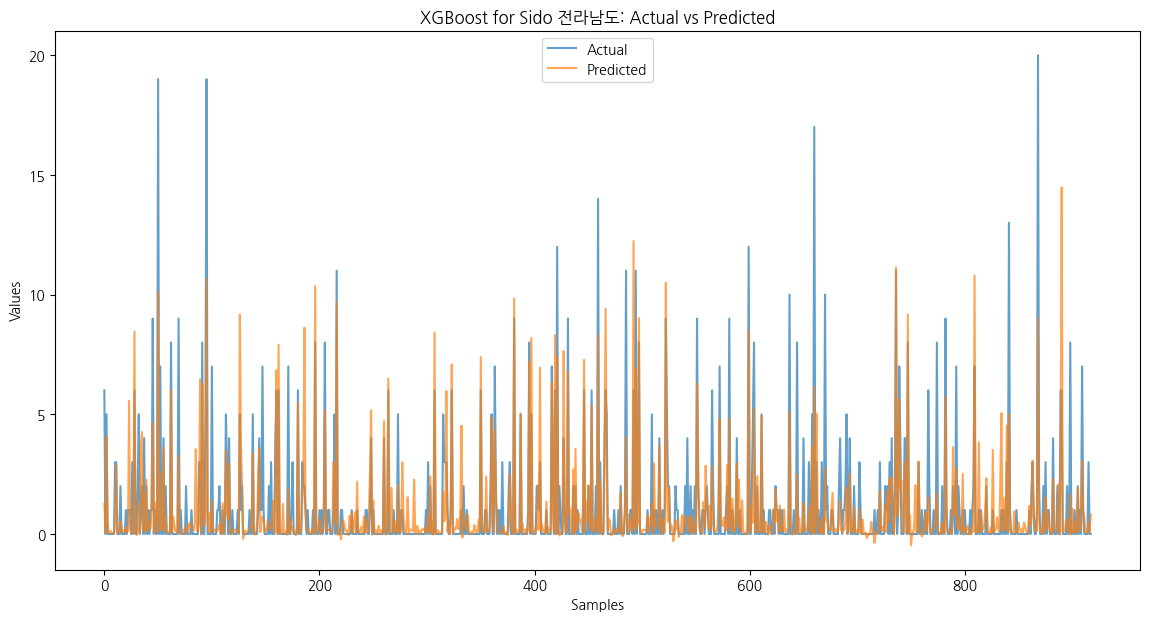

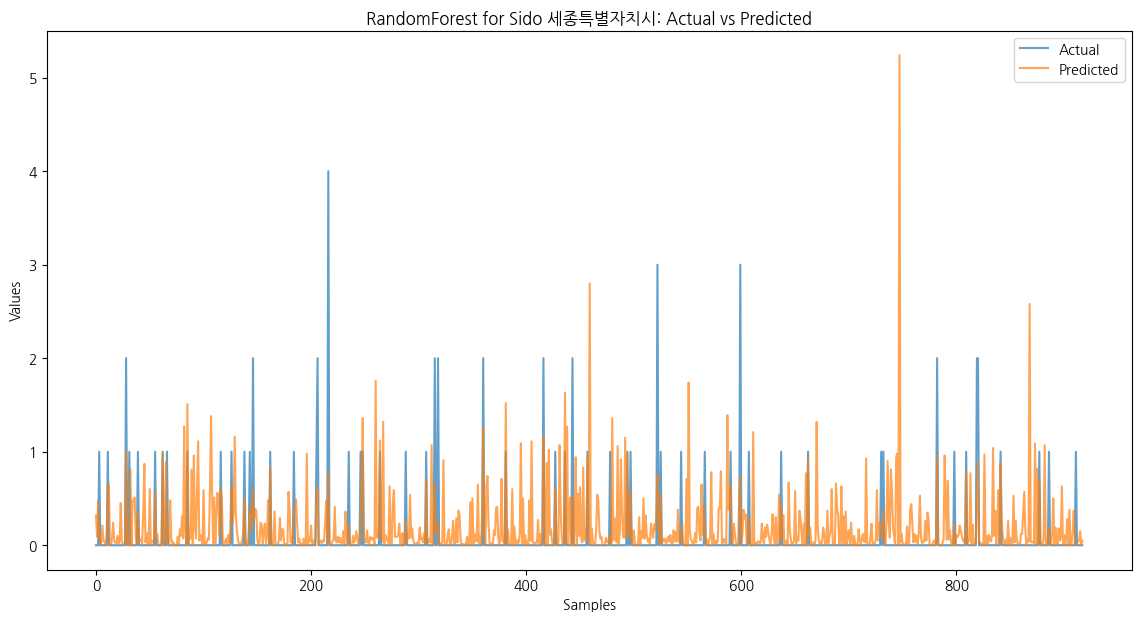

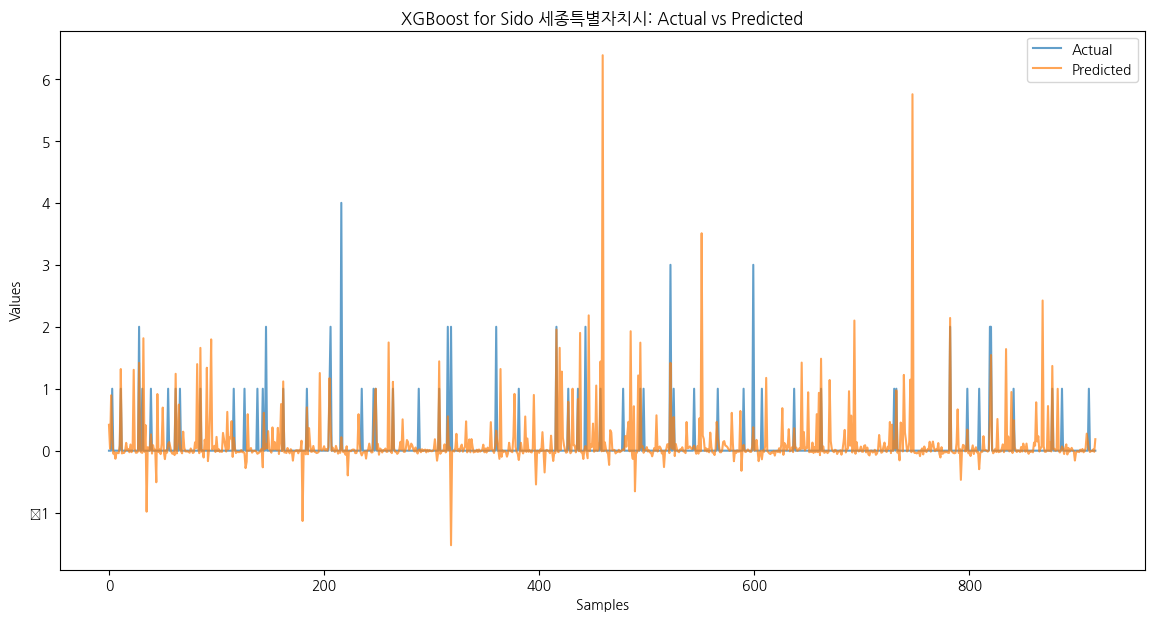

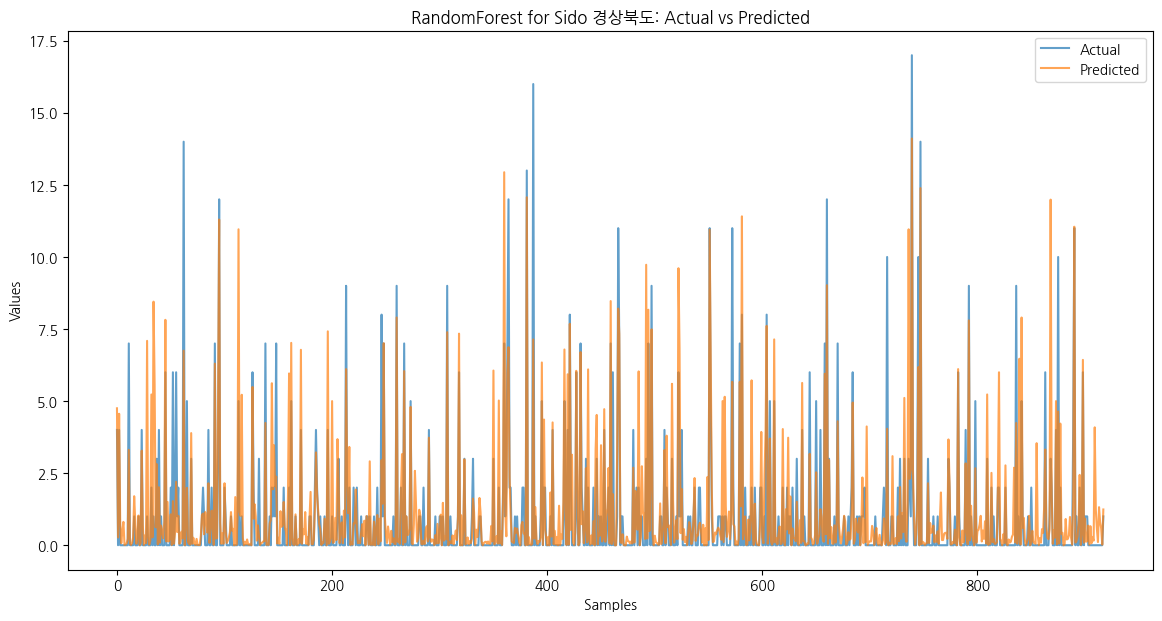

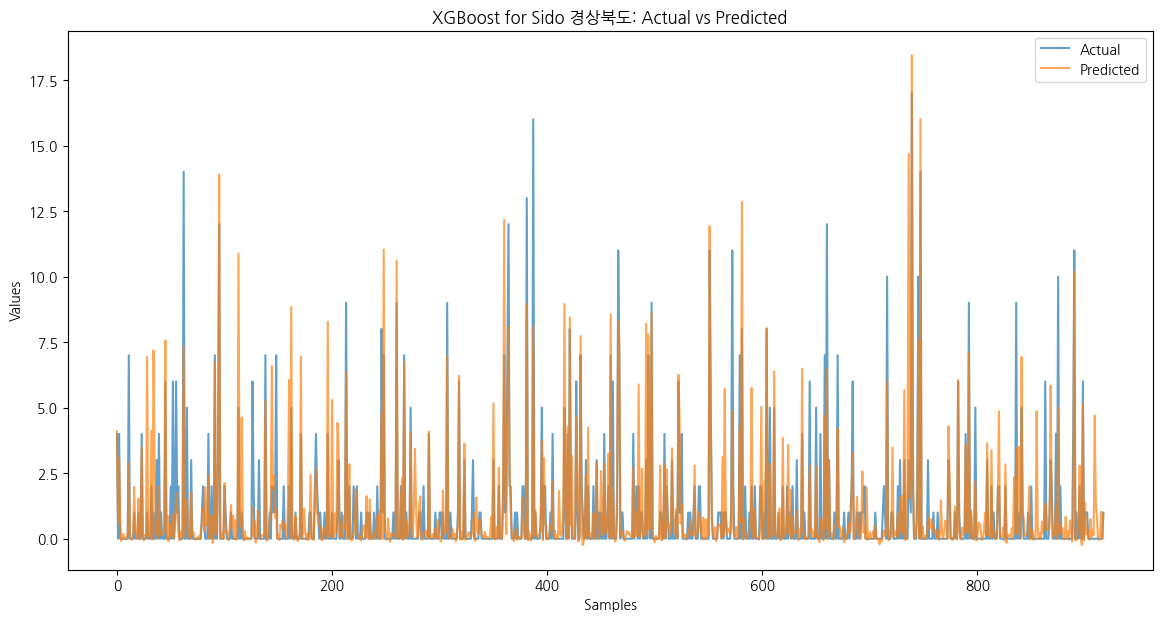

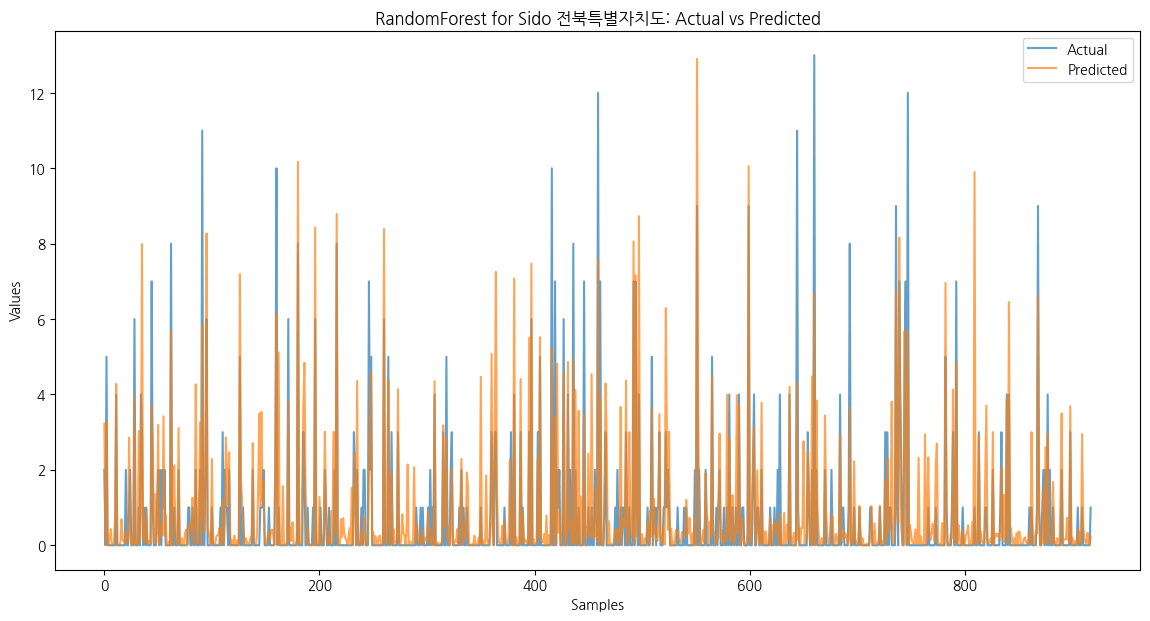

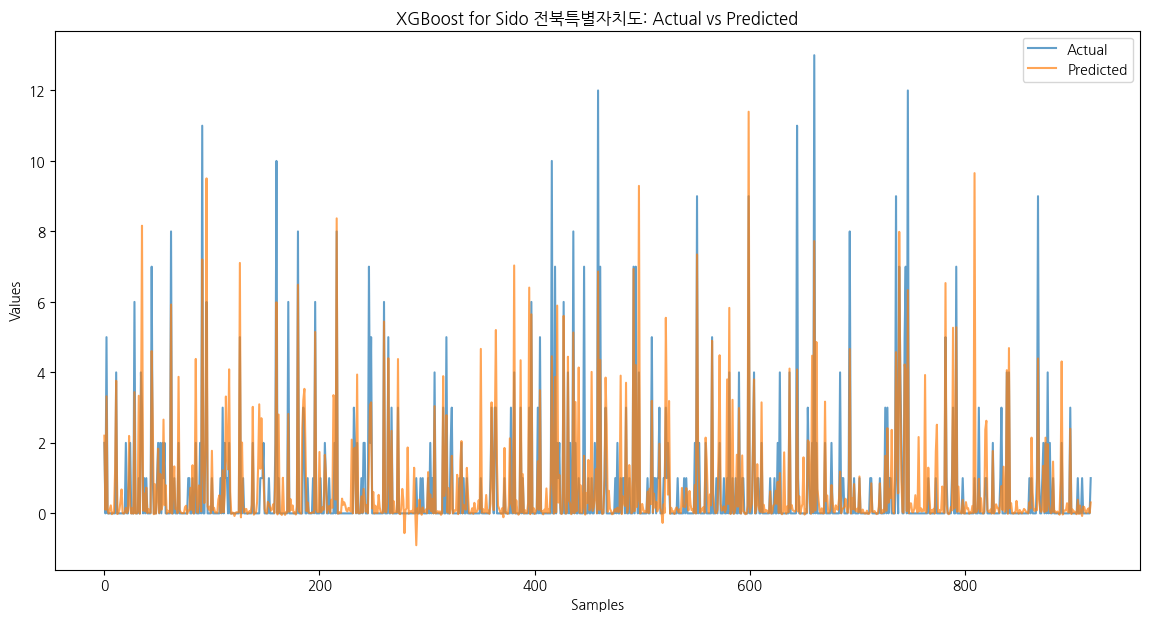

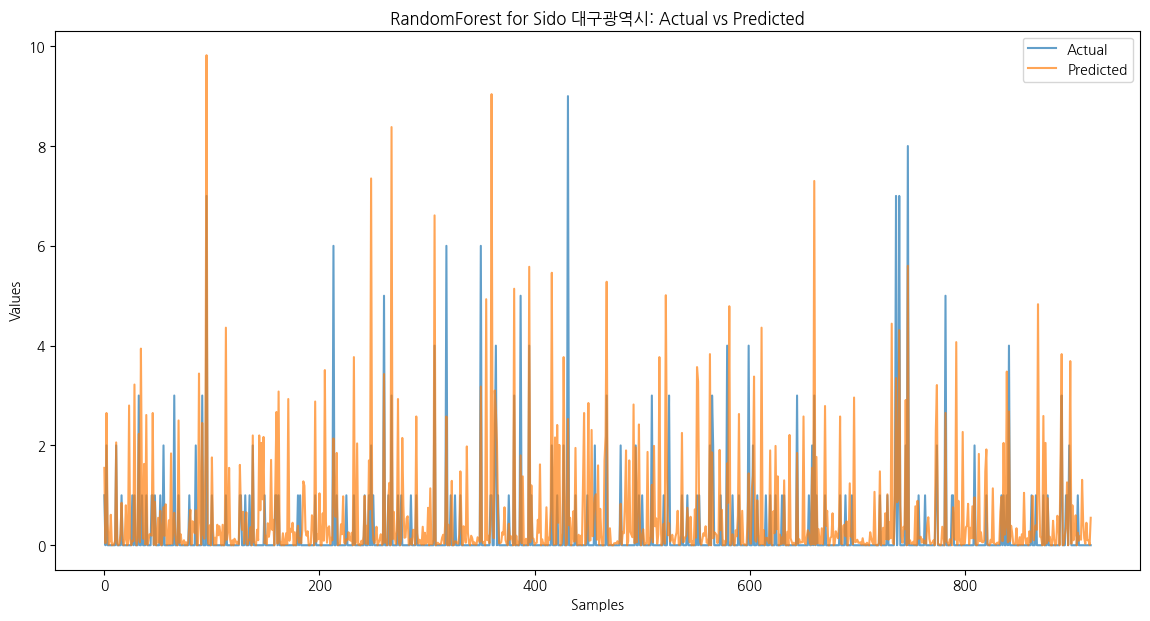

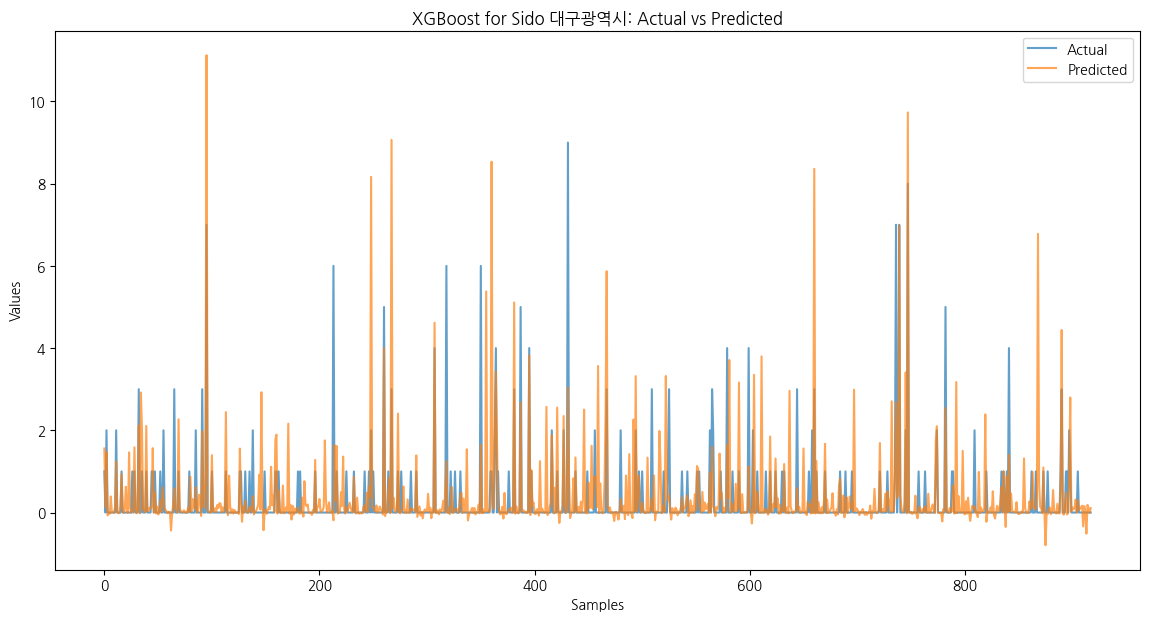

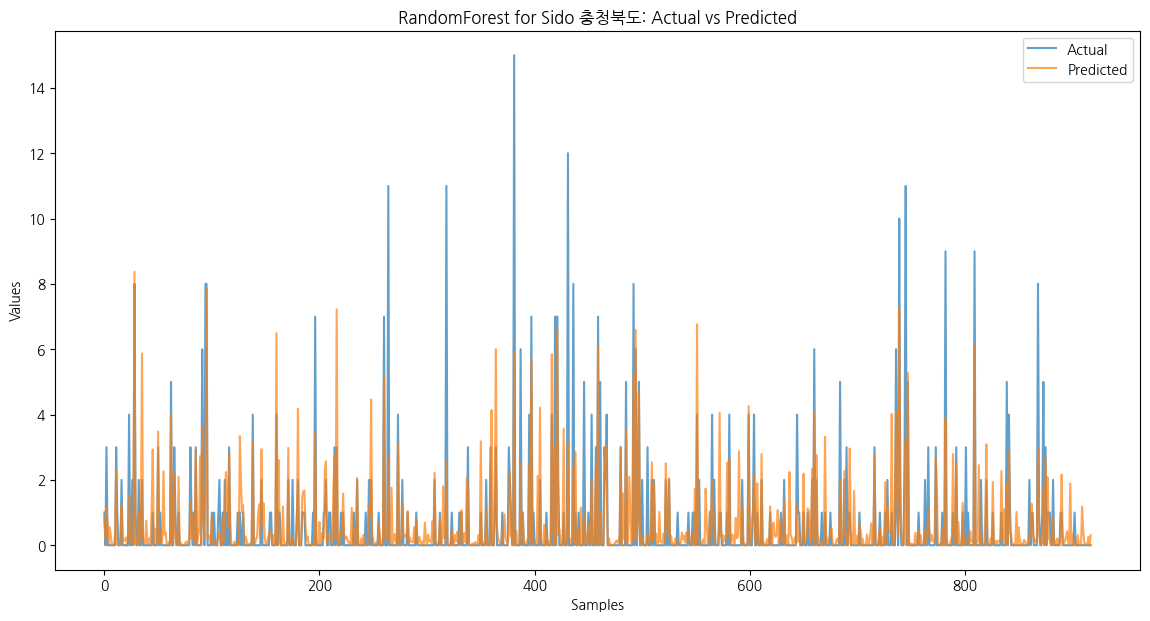

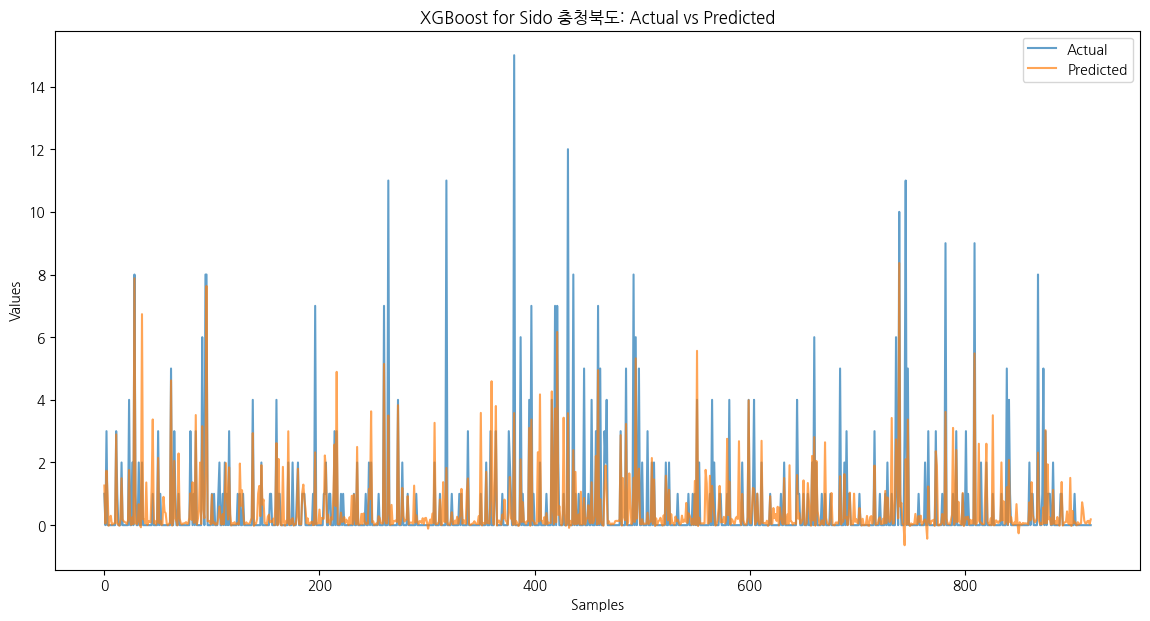

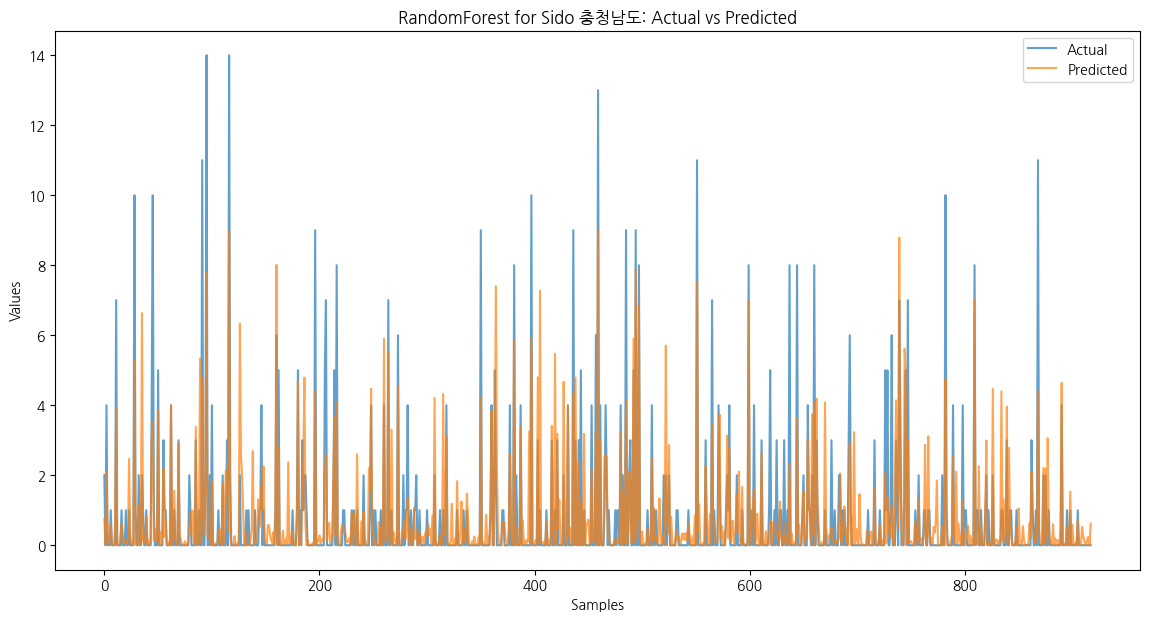

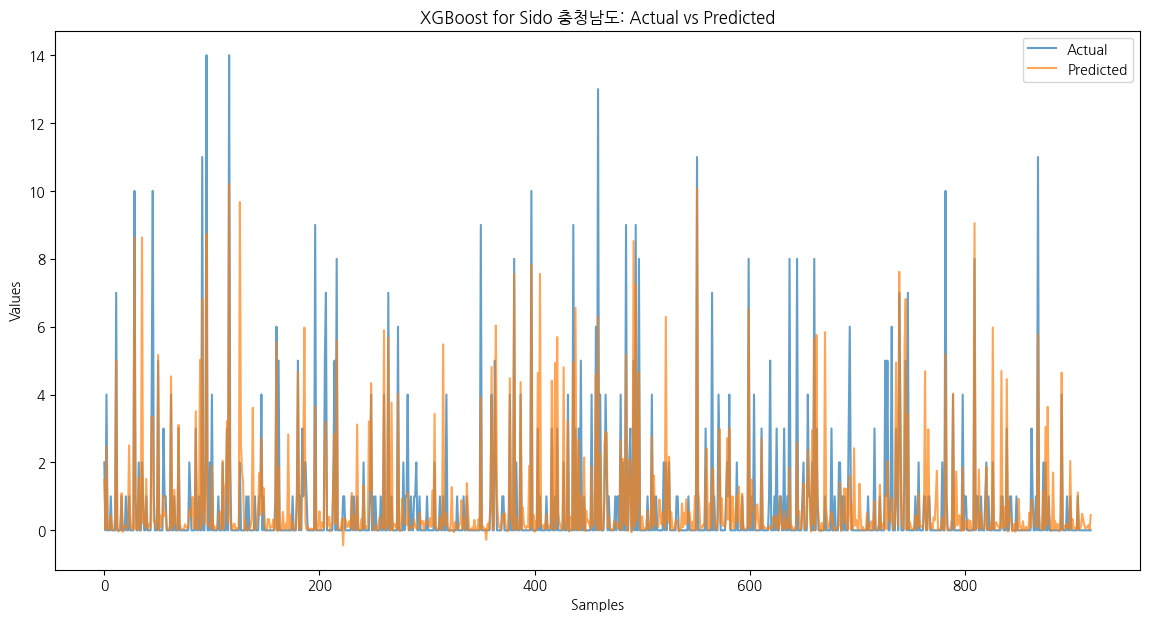

In [14]:
# 시각화
dt_map = {'39': '제주특별자치도', '32': '강원특별자치도', '25': '대전광역시','21': '부산광역시',
    '24': '광주광역시','26': '울산광역시', '38': '경상남도','23': '인천광역시',
    '31': '경기도','33': '충청북도', '22': '대구광역시','35': '전북특별자치도',
    '37': '경상북도','29': '세종특별자치시','36': '전라남도','11': '서울특별시','34': '충청남도'
}

for sido_cd, models in predictions.items():
    for model_name, (y_test, y_pred_test) in models.items():
        plt.figure(figsize=(14, 7))
        plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
        plt.plot(y_pred_test, label='Predicted', alpha=0.7)
        title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
        plt.title(f'{model_name} for Sido {title}: Actual vs Predicted')
        plt.savefig(f'{sido_cd}_actual_predict_rf_xgb')
        plt.xlabel('Samples')
        plt.ylabel('Values')
        plt.legend()
        plt.show()